<h1 style="text-align:center; color:green">Fiscal Fortunetelling: Data Mining for Loan Default Prediction</h1>

## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The purpose of this project is to develop a classification model that will allow us to predict the occurrence of loan default based on other factors within the data. Loan default is an extremely undesirable event for both lenders and borrowers. Funds that were loaned out to the borrower, which can often be large sums of money, are essentially losses. They can be recouped, at least in part, by various methods, but that process may take considerable time. The borrower may end up undergoing extreme financial hardship due to their default. Not to mention, their credit score will likely take a big hit. Since there are such high stakes for both parties, it is of utmost importance for lenders to properly assess the risk associated with each potential borrower in order to avoid incidences of loan default in the future if at all possible. Our goal is to build a classification model that takes various features as inputs and then predicts whether or not someone is likely to default on their loan. This information will be highly useful during the loan-approval decision-making process. For our project, we will utilize the data provided by Lending Club, an online peer-to-peer lending platform. The dataset is comprised of information associated with loans that were approved from 2007 to 2018.

## Part 1: Importing Packages and Data

In [1]:
# Import potentially useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from pandas.plotting import parallel_coordinates
import statsmodels.formula.api as sm
import math
import warnings

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from dmba import regressionSummary, classificationSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import liftChart, gainsChart, plotDecisionTree
from dmba import adjusted_r2_score, AIC_score, BIC_score
from imblearn.over_sampling import SMOTE

In [2]:
# Load the data
lending_club_df = pd.read_csv('/Users/williamjowens/Desktop/ANA 615/Week 4/lending_club.csv', low_memory=False)

In [3]:
# Preview the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

lending_club_df.head()

Unnamed: 0         loan_status  annual_inc    dti  delinq_2yrs  \
0      133423          Fully Paid    125000.0  20.81          0.0   
1      557225  Late (31-120 days)     23500.0  23.95          0.0   
2       80694             Current     63000.0   8.72          0.0   
3      651321          Fully Paid     40000.0  31.09          1.0   
4      150555             Current     90000.0  19.72          1.0   

   fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  \
0           675.0            679.0             0.0                    24.0   
1           665.0            669.0             0.0                    33.0   
2           745.0            749.0             1.0                     NaN   
3           680.0            684.0             1.0                    13.0   
4           705.0            709.0             3.0                     5.0   

   open_acc  revol_bal  revol_util  total_acc  
0      15.0    23337.0        58.9       23.0  
1       5.0     4009.0        35.5       11.0  
2       6.0     3045.0        20.7       10.0  
3      14.0    24950.0        53.8       26.0  
4      12.0    12729.0        23.2       26.0

## Part 2: Examining the Data

In [4]:
# Get size of data
lending_club_df.size

1363154

In [5]:
# Get shape of data
lending_club_df.shape

print('Number of Rows:    ', lending_club_df.shape[0])
print('Number of Columns: ', lending_club_df.shape[1])

Number of Rows:     104858
Number of Columns:  13


Upon initial examination of the data, we can see that there are 104,858 records in the dataset. Additionally, there are 13 columns present. Let's take a closer look at the column names.

In [6]:
# View each column
def column_name_dataframe(df):
    columns = df.columns.sort_values()
    return pd.DataFrame(columns, columns=['Column Name'])

column_df = column_name_dataframe(lending_club_df)
column_df

Column Name
0               Unnamed: 0
1               annual_inc
2              delinq_2yrs
3                      dti
4          fico_range_high
5           fico_range_low
6           inq_last_6mths
7              loan_status
8   mths_since_last_delinq
9                 open_acc
10               revol_bal
11              revol_util
12               total_acc

The earlier preview of the dataset suggested that the column "Unnamed: 0" is an index field, possibly meant to denote an individualized borrower ID. Let's examine the datatypes for each column.

In [7]:
# View datatypes for each variable
def datatype_dataframe(df):
    datatypes = df.dtypes.sort_values()
    return pd.DataFrame(datatypes, columns=['Datatype'])

dtypes_df = datatype_dataframe(lending_club_df)
dtypes_df

Datatype
Unnamed: 0                int64
annual_inc              float64
dti                     float64
delinq_2yrs             float64
fico_range_low          float64
fico_range_high         float64
inq_last_6mths          float64
mths_since_last_delinq  float64
open_acc                float64
revol_bal               float64
revol_util              float64
total_acc               float64
loan_status              object

Upon reviewing the datatypes for each column, we can see that all of the variables except for the index column ("Unnamed: 0") and "loan_status" are floats. In other words, all of our features are already in numeric format. The "loan_status" variable will eventually be transformed into a binary categorical variable in numeric format (0s and 1s).

In [8]:
# Examine with info() method
lending_club_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104858 entries, 0 to 104857
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              104858 non-null  int64  
 1   loan_status             104855 non-null  object 
 2   annual_inc              104855 non-null  float64
 3   dti                     104774 non-null  float64
 4   delinq_2yrs             104855 non-null  float64
 5   fico_range_low          104855 non-null  float64
 6   fico_range_high         104855 non-null  float64
 7   inq_last_6mths          104855 non-null  float64
 8   mths_since_last_delinq  52258 non-null   float64
 9   open_acc                104855 non-null  float64
 10  revol_bal               104855 non-null  float64
 11  revol_util              104776 non-null  float64
 12  total_acc               104855 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 10.4+ MB


In [9]:
# View number of unique values for each variable
def unique_values_dataframe(df):
    unique_value_counts = df.nunique().sort_values(ascending=False)
    return pd.DataFrame(unique_value_counts, columns=['Unique Count'])

unique_counts_df = unique_values_dataframe(lending_club_df)
unique_counts_df

Unique Count
Unnamed: 0                    104858
revol_bal                      37964
annual_inc                      9112
dti                             5101
revol_util                      1098
mths_since_last_delinq           130
total_acc                        108
open_acc                          63
fico_range_low                    38
fico_range_high                   38
delinq_2yrs                       22
loan_status                        7
inq_last_6mths                     7

After counting the number of unique values for each column, we can see that the column "Unnamed: 0" has the same number of unique values as the number of records in the dataset. This is consistent with our expectation that this column represents a borrower ID variable/index variable.

In [10]:
# View descriptive statistics pre-cleaning
lending_club_df.describe()

Unnamed: 0    annual_inc            dti    delinq_2yrs  \
count  1.048580e+05  1.048550e+05  104774.000000  104855.000000   
mean   5.241263e+05  7.794848e+04      19.277917       0.322779   
std    3.019130e+05  6.825177e+04      14.144876       0.918932   
min    1.000000e+00  0.000000e+00       0.000000       0.000000   
25%    2.633162e+05  4.600000e+04      12.190000       0.000000   
50%    5.248155e+05  6.500000e+04      18.255000       0.000000   
75%    7.852530e+05  9.400000e+04      25.120000       0.000000   
max    1.048570e+06  8.706582e+06     999.000000      58.000000   

       fico_range_low  fico_range_high  inq_last_6mths  \
count   104855.000000    104855.000000   104855.000000   
mean       698.040103       702.040313        0.522140   
std         32.918994        32.919934        0.820305   
min        660.000000       664.000000        0.000000   
25%        670.000000       674.000000        0.000000   
50%        690.000000       694.000000        0.000000   
75%        715.000000       719.000000        1.000000   
max        845.000000       850.000000        6.000000   

       mths_since_last_delinq       open_acc      revol_bal     revol_util  \
count            52258.000000  104855.000000  104855.000000  104776.000000   
mean                34.350721      11.775099   16783.977893      49.991264   
std                 21.973957       5.754406   22289.400553      24.619052   
min                  0.000000       0.000000       0.000000       0.000000   
25%                 16.000000       8.000000    5939.500000      31.300000   
50%                 31.000000      11.000000   11334.000000      49.600000   
75%                 50.000000      15.000000   20410.500000      68.800000   
max                158.000000      66.000000  959754.000000     155.300000   

           total_acc  
count  104855.000000  
mean       24.233437  
std        12.081295  
min         2.000000  
25%        15.000000  
50%        22.000000  
75%        31.000000  
max       160.000000

## Analysis of Descriptive Statistics
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An initial inspection of the descriptive statistics reveals some interesting information. Firstly, the variable "annual_inc" has a wide-ranging data distribution, with the minimum value equal to 0 and the maximum value equaling approximately 8.7 million. In addition, the standard deviation for this variable is quite large, indicating high variability. The data distribution for the variable "dti" also possesses a wide range, with a minimum value of 0 and a maximum value of 999. Judging by the 75th percentile values for the variables "annual_inc" and "dti", we can see that most of the values for these variables fall within a reasonable range. However, there are individuals with extremely high annual income and individuals with extremely high dti who are at the far end of the data distribution. It is more than likely that we will see right-skewed distributions and outliers for these two variables.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's also take a look at the variables "fico_range_low" and "fico_range_high" next. Although these two variables collectively represent a credit score range, their mean values appear to differ by only 4 points. In addition, both of these variables have strikingly similar standard deviation values. After investigating further, we noticed that the other descriptive statistics for these variables only differ by 4 or 5 points as well. The distributions for these two variables will be virtually identical and this is all suggestive of collinearity between the low and high fico range variables. The variable "mths_since_last_delinq" has 52,258 records, indicating that this variable is missing a substantial amount of data. The last four variables: "open_acc", "revol_bal", "revol_util", and "total_acc" appear to possess distribution characteristics that are quite similar to the first two variables that we examined. They have minima of 0 or nearly 0 and maxima that are extremely high relative to the rest of the data. The distributions for these variables are likely right-skewed and probably contain outliers.

## Part 3: Data Cleaning

In [11]:
# Examine missing values in a table
def missing_values_table(df):
    missing_values_df = pd.DataFrame(df.isnull().sum(), columns=['Missing Count'])
    
    missing_values_df['Percent Missing'] = missing_values_df['Missing Count']/df.shape[0] * 100
    
    missing_values_df = missing_values_df.sort_values(by='Missing Count', ascending=False)
    
    return missing_values_df

missing_values_df = missing_values_table(lending_club_df)
missing_values_df

Missing Count  Percent Missing
mths_since_last_delinq          52600        50.163078
dti                                84         0.080108
revol_util                         82         0.078201
loan_status                         3         0.002861
annual_inc                          3         0.002861
delinq_2yrs                         3         0.002861
fico_range_low                      3         0.002861
fico_range_high                     3         0.002861
inq_last_6mths                      3         0.002861
open_acc                            3         0.002861
revol_bal                           3         0.002861
total_acc                           3         0.002861
Unnamed: 0                          0         0.000000

As we noted earlier, the "mths_since_last_delinq" variable has more than 50,000 missing values, or a little over half of the number of rows in our dataset. The variables "dti" and "revol_util" each have a little over 80 missing records. The rest of the variables are only missing 3 values each. Because "mths_since_last_delinq" has more than 50% missing values, we do not think that it will provide useful information for the modeling process. Moreover, we do not think it is appropriate to impute the missing data in a case such as this where over half of the records are missing. As a result, we will be removing this variable from the dataset going forward. We will also be removing the index-like variable "Unnamed: 0" since it has no utility or relevance in the subsqeuent analysis and modeling tasks.

In [12]:
# Remove column with over 50% missing values
def remove_columns_over_threshold(df, threshold=50):
    missing_values_df = missing_values_table(df)
    
    filtered_df = df[missing_values_df[missing_values_df['Percent Missing'] < threshold].index]
    
    return filtered_df

lending_club_df = remove_columns_over_threshold(lending_club_df)

lending_club_df.head()

dti  revol_util         loan_status  annual_inc  delinq_2yrs  \
0  20.81        58.9          Fully Paid    125000.0          0.0   
1  23.95        35.5  Late (31-120 days)     23500.0          0.0   
2   8.72        20.7             Current     63000.0          0.0   
3  31.09        53.8          Fully Paid     40000.0          1.0   
4  19.72        23.2             Current     90000.0          1.0   

   fico_range_low  fico_range_high  inq_last_6mths  open_acc  revol_bal  \
0           675.0            679.0             0.0      15.0    23337.0   
1           665.0            669.0             0.0       5.0     4009.0   
2           745.0            749.0             1.0       6.0     3045.0   
3           680.0            684.0             1.0      14.0    24950.0   
4           705.0            709.0             3.0      12.0    12729.0   

   total_acc  Unnamed: 0  
0       23.0      133423  
1       11.0      557225  
2       10.0       80694  
3       26.0      651321  
4       26.0      150555

In [13]:
# Remove column that appears to represent an index
lending_club_df = lending_club_df.drop(columns='Unnamed: 0')

lending_club_df.head()

dti  revol_util         loan_status  annual_inc  delinq_2yrs  \
0  20.81        58.9          Fully Paid    125000.0          0.0   
1  23.95        35.5  Late (31-120 days)     23500.0          0.0   
2   8.72        20.7             Current     63000.0          0.0   
3  31.09        53.8          Fully Paid     40000.0          1.0   
4  19.72        23.2             Current     90000.0          1.0   

   fico_range_low  fico_range_high  inq_last_6mths  open_acc  revol_bal  \
0           675.0            679.0             0.0      15.0    23337.0   
1           665.0            669.0             0.0       5.0     4009.0   
2           745.0            749.0             1.0       6.0     3045.0   
3           680.0            684.0             1.0      14.0    24950.0   
4           705.0            709.0             3.0      12.0    12729.0   

   total_acc  
0       23.0  
1       11.0  
2       10.0  
3       26.0  
4       26.0

An important issue to consider is the problem of target leakage. This refers to a situation where the predictive model is given access to data that would not have been available at the time of prediction. In other words, the set of features used to train the model includes data that is from a future point in time. This can lead to overly optimistic performance estimates that will probably fail to carry over when confronted with novel data.

The variables "inq_last_6mths" and "delinq_2yrs" may represent information that was not known at the time of loan approval. If these variables contain data recorded over the course of the loan (in the past six months and the past two years, respectively), then including these variables could result in target leakage. Consequently, we will be removing these two variables from the dataset.

In [14]:
# Remove columns that may contain information we may not have known at the time of loan approval
lending_club_df = lending_club_df.drop(columns=['inq_last_6mths', 'delinq_2yrs'])

lending_club_df.head(10)

dti  revol_util         loan_status  annual_inc  fico_range_low  \
0  20.81        58.9          Fully Paid    125000.0           675.0   
1  23.95        35.5  Late (31-120 days)     23500.0           665.0   
2   8.72        20.7             Current     63000.0           745.0   
3  31.09        53.8          Fully Paid     40000.0           680.0   
4  19.72        23.2             Current     90000.0           705.0   
5  10.53        59.6          Fully Paid    120000.0           660.0   
6   9.03         6.8          Fully Paid    225000.0           665.0   
7  15.33        49.0          Fully Paid     94000.0           660.0   
8  22.29        82.3             Current     80000.0           695.0   
9  29.32        80.9          Fully Paid     46000.0           665.0   

   fico_range_high  open_acc  revol_bal  total_acc  
0            679.0      15.0    23337.0       23.0  
1            669.0       5.0     4009.0       11.0  
2            749.0       6.0     3045.0       10.0  
3            684.0      14.0    24950.0       26.0  
4            709.0      12.0    12729.0       26.0  
5            664.0       8.0     5901.0       34.0  
6            669.0      10.0      542.0       30.0  
7            664.0      12.0     6125.0       30.0  
8            699.0      19.0    29645.0       36.0  
9            669.0       8.0     4287.0       16.0

Next, we will need to encode our target variable, "loan_status", as a binary categorical variable. Our strategy will be to encode instances of the "Charged Off" category as values of 1. Instances of all other categories will be encoded as values of 0.

In [15]:
# Examine target variable categories
lending_club_df['loan_status'].value_counts()

Fully Paid            48162
Current               42122
Charged Off           12851
Late (31-120 days)     1080
In Grace Period         418
Late (16-30 days)       220
Default                   2
Name: loan_status, dtype: int64

In [16]:
# Convert 'loan_status' to binary variable
def convert_category_to_binary(df, column, category_name):
    df[column] = np.where(df[column] == category_name, 1, 0)
    return df

lending_club_df = convert_category_to_binary(lending_club_df, 'loan_status', 'Charged Off')

lending_club_df.head()

dti  revol_util  loan_status  annual_inc  fico_range_low  \
0  20.81        58.9            0    125000.0           675.0   
1  23.95        35.5            0     23500.0           665.0   
2   8.72        20.7            0     63000.0           745.0   
3  31.09        53.8            0     40000.0           680.0   
4  19.72        23.2            0     90000.0           705.0   

   fico_range_high  open_acc  revol_bal  total_acc  
0            679.0      15.0    23337.0       23.0  
1            669.0       5.0     4009.0       11.0  
2            749.0       6.0     3045.0       10.0  
3            684.0      14.0    24950.0       26.0  
4            709.0      12.0    12729.0       26.0

There are still missing values that remain in our dataset. We will address these missing values by imputing them via the K-Nearest Neighbors method. When considering the value of K for our imputation, we must keep in mind that a small K-value may result in our imputation being overly influenced by noise and a large K-value may result in our imputation being overly influenced by irrelevant instances. We will be using a K-value of 5 to strike an optimal balance between noise and irrelevance.

In [17]:
# Impute missing values with KNN
imputer = KNNImputer(n_neighbors=5)
imputed_df = pd.DataFrame(imputer.fit_transform(lending_club_df), columns=lending_club_df.columns)

imputed_df.head()

dti  revol_util  loan_status  annual_inc  fico_range_low  \
0  20.81        58.9          0.0    125000.0           675.0   
1  23.95        35.5          0.0     23500.0           665.0   
2   8.72        20.7          0.0     63000.0           745.0   
3  31.09        53.8          0.0     40000.0           680.0   
4  19.72        23.2          0.0     90000.0           705.0   

   fico_range_high  open_acc  revol_bal  total_acc  
0            679.0      15.0    23337.0       23.0  
1            669.0       5.0     4009.0       11.0  
2            749.0       6.0     3045.0       10.0  
3            684.0      14.0    24950.0       26.0  
4            709.0      12.0    12729.0       26.0

In [18]:
# Check that we have no missing values
missing_values_df = missing_values_table(imputed_df)
missing_values_df

Missing Count  Percent Missing
dti                          0              0.0
revol_util                   0              0.0
loan_status                  0              0.0
annual_inc                   0              0.0
fico_range_low               0              0.0
fico_range_high              0              0.0
open_acc                     0              0.0
revol_bal                    0              0.0
total_acc                    0              0.0

## Part 4: Exploratory Data Analysis

In [19]:
# Examine descriptive statistics and other information post-cleaning
def custom_stats_dataframe(df):
    df = pd.DataFrame({
            'Mean': df.mean(),
            'SD': df.std(),
            'Min': df.min(),
            'Max': df.max(),
            'Median': df.median(),
            'Skew': df.skew(),
            'Length': len(df),
            'Missing': df.isnull().sum()
    })
    
    return df

descriptive_stats_df = custom_stats_dataframe(imputed_df)
descriptive_stats_df

Mean            SD    Min        Max    Median  \
dti                 19.666531     20.238935    0.0      999.0     18.26   
revol_util          49.962104     24.639695    0.0      155.3     49.60   
loan_status          0.122556      0.327929    0.0        1.0      0.00   
annual_inc       77948.427141  68250.795388    0.0  8706582.0  65000.00   
fico_range_low     698.040045     32.918525  660.0      845.0    690.00   
fico_range_high    702.040254     32.919465  664.0      850.0    694.00   
open_acc            11.775060      5.754328    0.0       66.0     11.00   
revol_bal        16783.676498  22289.152920    0.0   959754.0  11334.00   
total_acc           24.233350     12.081133    2.0      160.0     22.00   

                      Skew  Length  Missing  
dti              23.847092  104858        0  
revol_util        0.026320  104858        0  
loan_status       2.302031  104858        0  
annual_inc       36.878153  104858        0  
fico_range_low    1.214689  104858        0  
fico_range_high   1.214949  104858        0  
open_acc          1.291416  104858        0  
revol_bal         9.033004  104858        0  
total_acc         1.028812  104858        0

After imputing missing values and re-examining the descriptive statistics of our remaining variables, it appears that the original structure of the data has been well-preserved. We have not noticed any major changes to the original data distributions. We have added a skewness statistic to our table, and as expected, "annual_inc" and "dti" have incredibly high skewness values. Let's examine the distributions more closely via the histograms and boxplots of each variable.

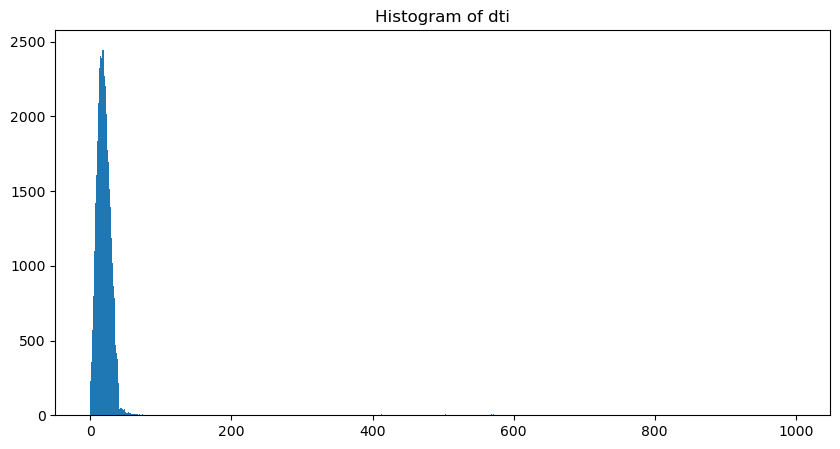

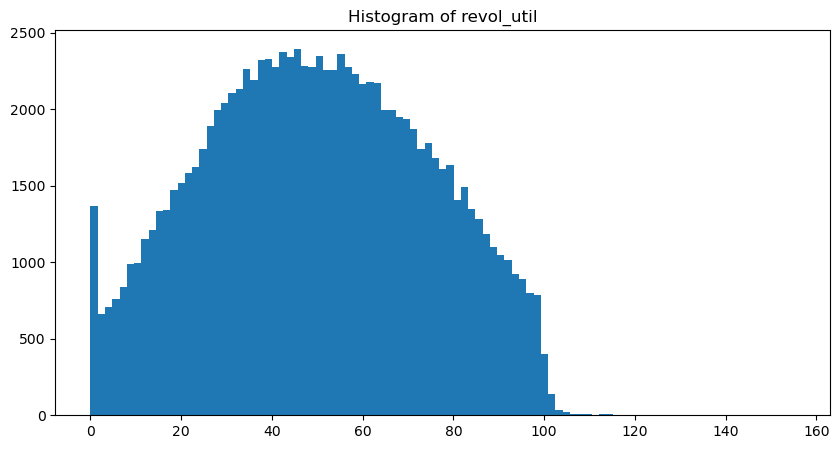

<Figure size 1000x500 with 0 Axes>

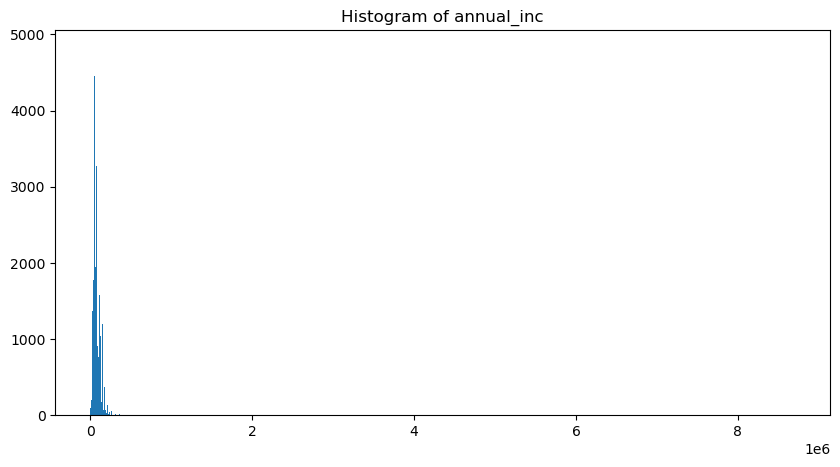

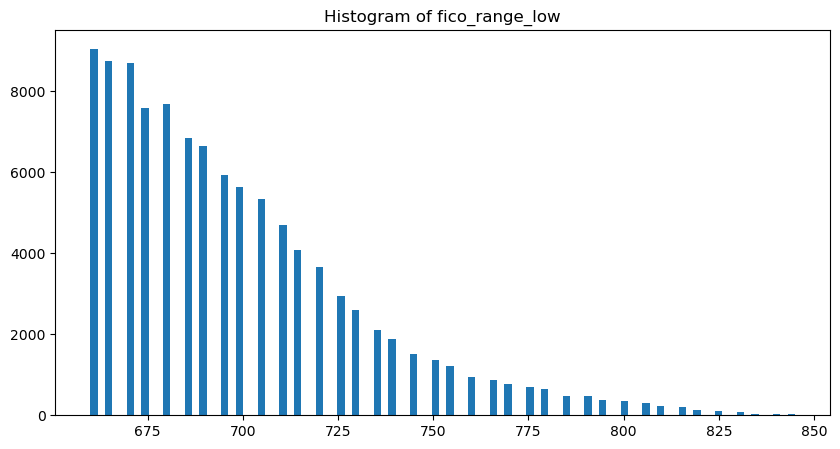

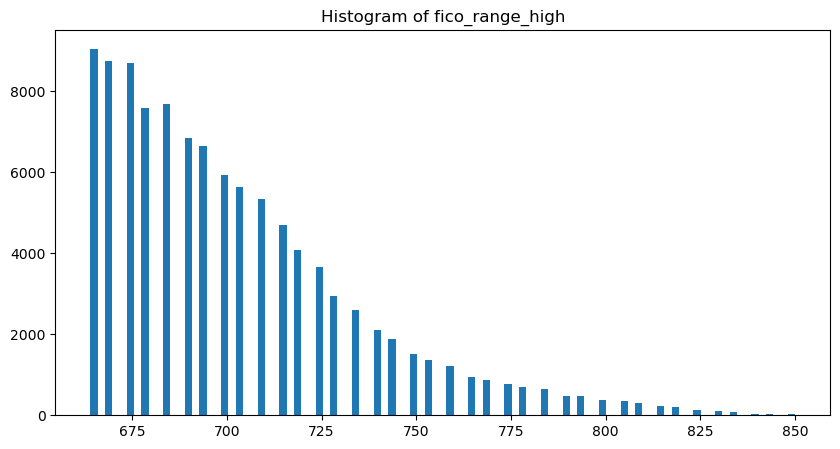

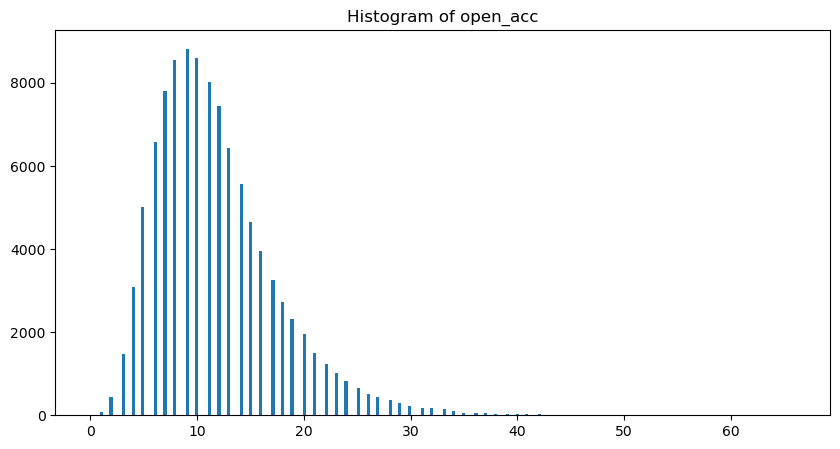

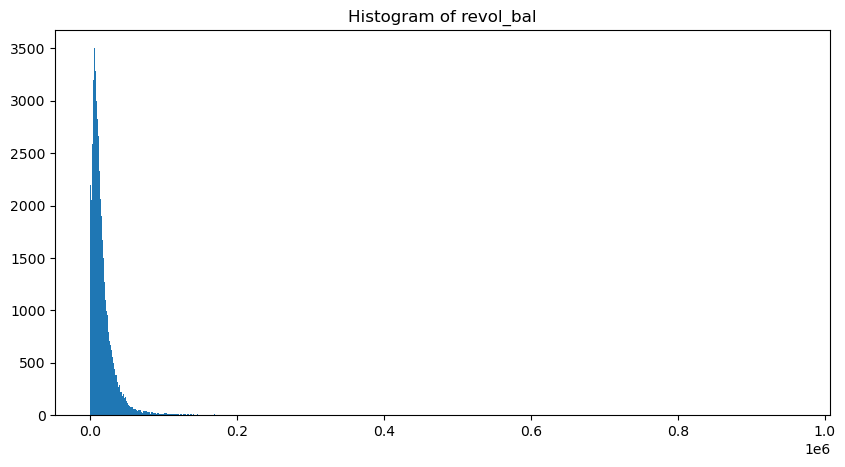

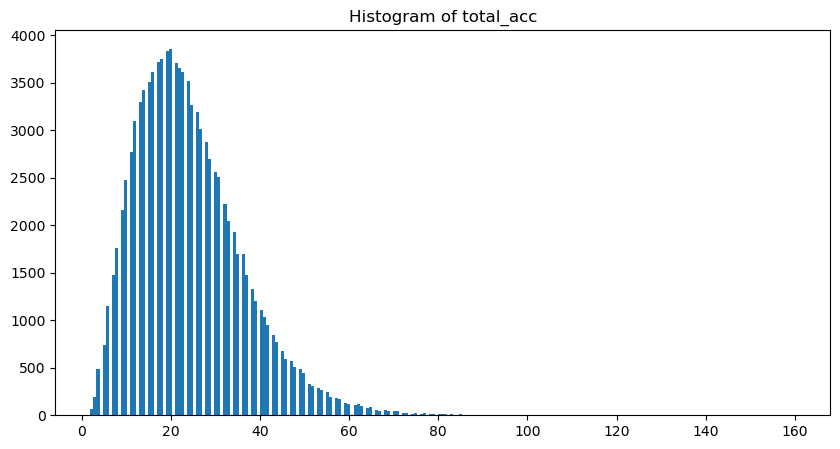

In [20]:
# Plot histograms for the continuous variables (bins are adjusted to the variable being plotted) 
def plot_histograms_all_variables(df):
    for column in df.columns:
        plt.figure(figsize=(10,5))
        n = len(df[column])
        IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
        if IQR == 0:
            continue
        else:
            bin_width = 2 * IQR * (n ** (-1/3))
            bins = round((df[column].max() - df[column].min()) / bin_width)
            plt.hist(df[column], bins=int(bins))
        plt.title(f'Histogram of {column}')
        plt.show()
        
histograms = plot_histograms_all_variables(imputed_df)
histograms

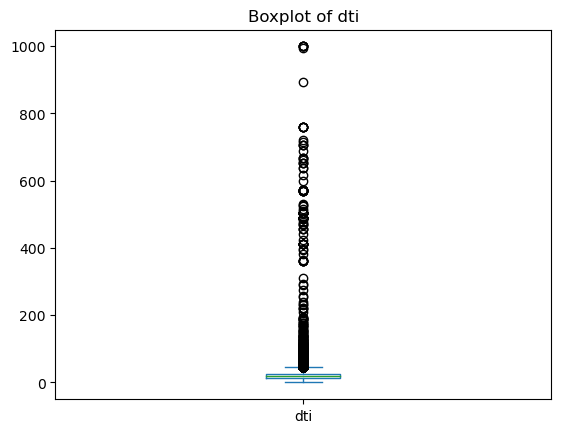

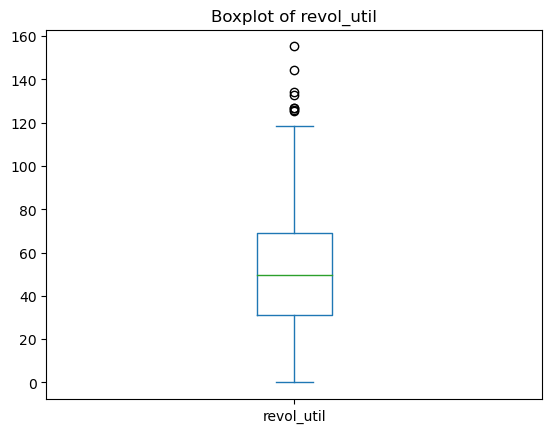

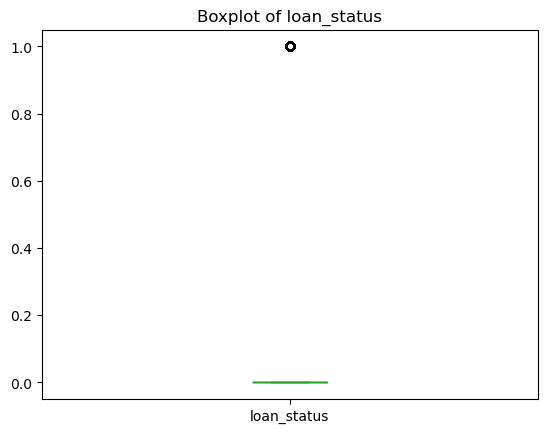

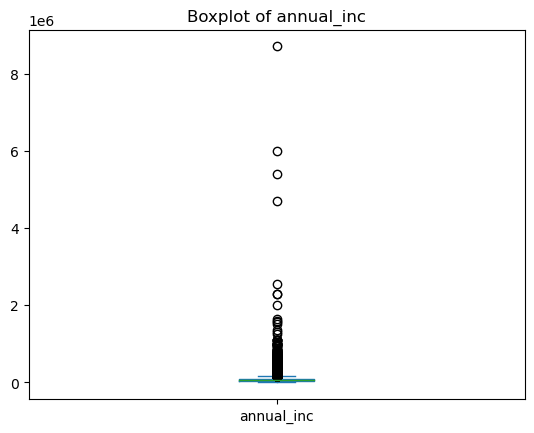

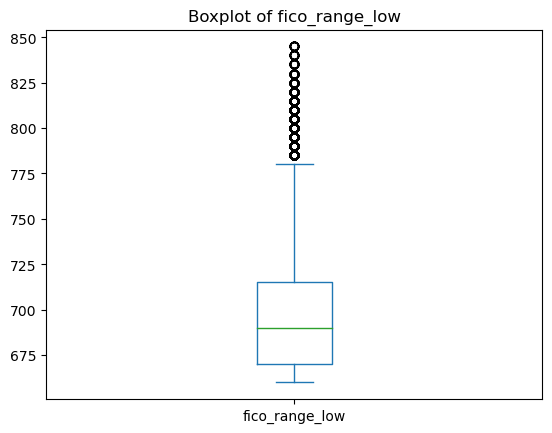

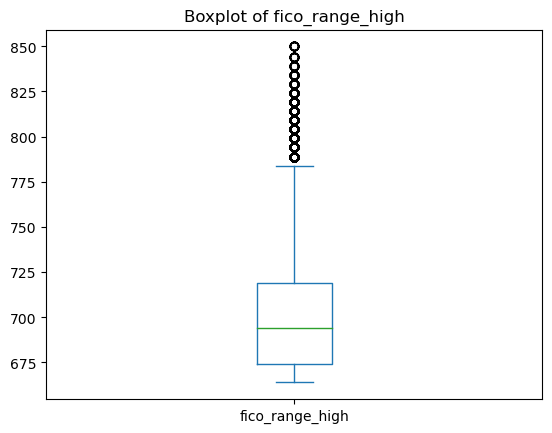

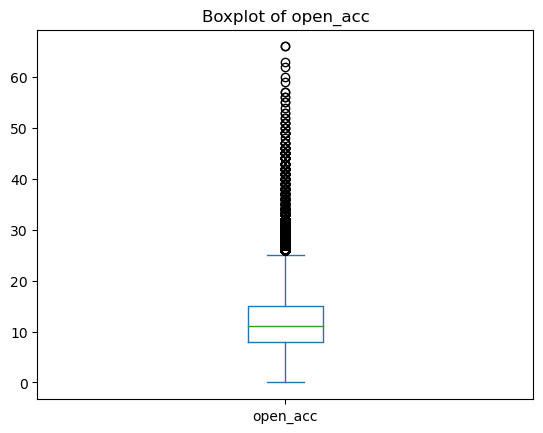

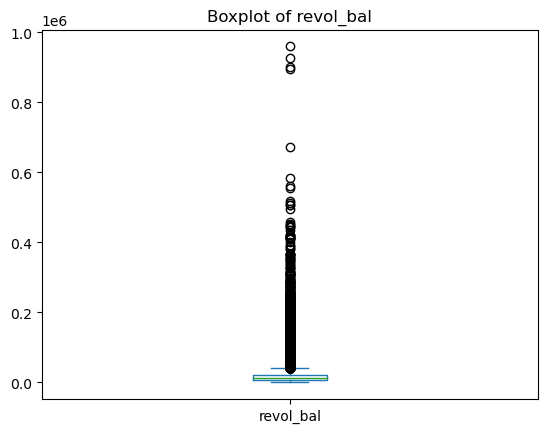

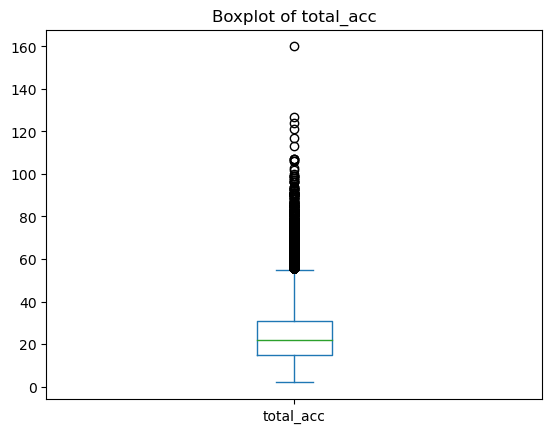

In [21]:
# Plot boxplots for the variables
def plot_boxplots_all_variables(df):
    for column in df.columns:
        df[column].plot(kind='box')
        plt.title(f'Boxplot of {column}')
        plt.show()
        
boxplots = plot_boxplots_all_variables(imputed_df)
boxplots

We can see from the histograms and boxplots above that virtually all of our continuous variables have a rightward skew with a considerable amount of outliers. The only continuous variable that does not meet this pattern is "revol_util", which is the most normally distributed of all the remaining variables. Next, we will inspect the correlational structure of the data.

In [22]:
# Examine correlational structure of the data
corr = imputed_df.corr()
corr

dti  revol_util  loan_status  annual_inc  \
dti              1.000000    0.084864     0.022251   -0.120145   
revol_util       0.084864    1.000000     0.052535    0.051958   
loan_status      0.022251    0.052535     1.000000   -0.038501   
annual_inc      -0.120145    0.051958    -0.038501    1.000000   
fico_range_low  -0.008794   -0.465072    -0.121300    0.058547   
fico_range_high -0.008797   -0.465071    -0.121298    0.058546   
open_acc         0.118807   -0.135262     0.019891    0.156924   
revol_bal        0.071558    0.263783    -0.025656    0.316277   
total_acc        0.093419   -0.098841     0.017405    0.189528   

                 fico_range_low  fico_range_high  open_acc  revol_bal  \
dti                   -0.008794        -0.008797  0.118807   0.071558   
revol_util            -0.465072        -0.465071 -0.135262   0.263783   
loan_status           -0.121300        -0.121298  0.019891  -0.025656   
annual_inc             0.058547         0.058546  0.156924   0.316277   
fico_range_low         1.000000         1.000000  0.022983   0.010615   
fico_range_high        1.000000         1.000000  0.022981   0.010611   
open_acc               0.022983         0.022981  1.000000   0.244079   
revol_bal              0.010615         0.010611  0.244079   1.000000   
total_acc              0.012097         0.012096  0.724488   0.207453   

                 total_acc  
dti               0.093419  
revol_util       -0.098841  
loan_status       0.017405  
annual_inc        0.189528  
fico_range_low    0.012097  
fico_range_high   0.012096  
open_acc          0.724488  
revol_bal         0.207453  
total_acc         1.000000

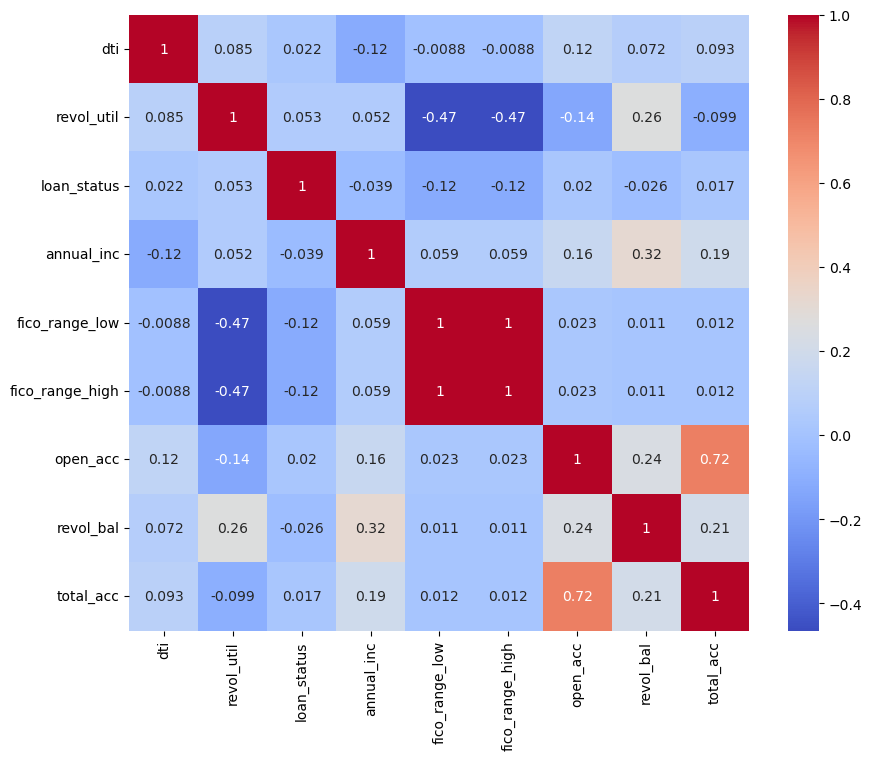

In [23]:
# Plot heatmap of correlations
def plot_correlation_heatmap(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()
    
heatmap = plot_correlation_heatmap(imputed_df)
heatmap

In [24]:
# Examine correlations in a sorted dataframe
def sorted_correlation_dataframe(df):
    corr = df.corr()
    
    corr_df = corr.unstack().sort_values(kind="quicksort", key=abs, ascending=False).reset_index()
    
    corr_df.columns = ['Variable 1', 'Variable 2', 'Correlation']
    
    corr_df = corr_df[corr_df['Variable 1'] != corr_df['Variable 2']]
    
    return corr_df

correlation_df = sorted_correlation_dataframe(imputed_df)
correlation_df

Variable 1       Variable 2  Correlation
9   fico_range_high   fico_range_low     1.000000
10   fico_range_low  fico_range_high     1.000000
11        total_acc         open_acc     0.724488
12         open_acc        total_acc     0.724488
13       revol_util   fico_range_low    -0.465072
14   fico_range_low       revol_util    -0.465072
15  fico_range_high       revol_util    -0.465071
16       revol_util  fico_range_high    -0.465071
17       annual_inc        revol_bal     0.316277
18        revol_bal       annual_inc     0.316277
19        revol_bal       revol_util     0.263783
20       revol_util        revol_bal     0.263783
21        revol_bal         open_acc     0.244079
22         open_acc        revol_bal     0.244079
23        revol_bal        total_acc     0.207453
24        total_acc        revol_bal     0.207453
25       annual_inc        total_acc     0.189528
26        total_acc       annual_inc     0.189528
27         open_acc       annual_inc     0.156924
28       annual_inc         open_acc     0.156924
29       revol_util         open_acc    -0.135262
30         open_acc       revol_util    -0.135262
31      loan_status   fico_range_low    -0.121300
32   fico_range_low      loan_status    -0.121300
33      loan_status  fico_range_high    -0.121298
34  fico_range_high      loan_status    -0.121298
35              dti       annual_inc    -0.120145
36       annual_inc              dti    -0.120145
37         open_acc              dti     0.118807
38              dti         open_acc     0.118807
39       revol_util        total_acc    -0.098841
40        total_acc       revol_util    -0.098841
41        total_acc              dti     0.093419
42              dti        total_acc     0.093419
43              dti       revol_util     0.084864
44       revol_util              dti     0.084864
45              dti        revol_bal     0.071558
46        revol_bal              dti     0.071558
47   fico_range_low       annual_inc     0.058547
48       annual_inc   fico_range_low     0.058547
49       annual_inc  fico_range_high     0.058546
50  fico_range_high       annual_inc     0.058546
51      loan_status       revol_util     0.052535
52       revol_util      loan_status     0.052535
53       annual_inc       revol_util     0.051958
54       revol_util       annual_inc     0.051958
55      loan_status       annual_inc    -0.038501
56       annual_inc      loan_status    -0.038501
57        revol_bal      loan_status    -0.025656
58      loan_status        revol_bal    -0.025656
59         open_acc   fico_range_low     0.022983
60   fico_range_low         open_acc     0.022983
61         open_acc  fico_range_high     0.022981
62  fico_range_high         open_acc     0.022981
63              dti      loan_status     0.022251
64      loan_status              dti     0.022251
65         open_acc      loan_status     0.019891
66      loan_status         open_acc     0.019891
67      loan_status        total_acc     0.017405
68        total_acc      loan_status     0.017405
69        total_acc   fico_range_low     0.012097
70   fico_range_low        total_acc     0.012097
71  fico_range_high        total_acc     0.012096
72        total_acc  fico_range_high     0.012096
73        revol_bal   fico_range_low     0.010615
74   fico_range_low        revol_bal     0.010615
75        revol_bal  fico_range_high     0.010611
76  fico_range_high        revol_bal     0.010611
77              dti  fico_range_high    -0.008797
78  fico_range_high              dti    -0.008797
79   fico_range_low              dti    -0.008794
80              dti   fico_range_low    -0.008794

In [25]:
# Examine correlations with the target variable
def sorted_correlation_with_target(df, target_column):
    correlations = df.corr()[target_column].drop(target_column)
    correlations_df = pd.DataFrame(correlations).reset_index().rename(columns={
        'index': 'Variable',
         target_column: 'Correlation with Target'
    })
    
    correlations_df['absolute_correlation'] = correlations_df['Correlation with Target'].abs()
    
    correlations_df = correlations_df.sort_values(by=['absolute_correlation', 'Correlation with Target'], ascending=[False, False])
    
    correlations_df = correlations_df.drop(columns='absolute_correlation')
    
    return correlations_df

sorted_correlation_df = sorted_correlation_with_target(imputed_df, 'loan_status')
sorted_correlation_df

Variable  Correlation with Target
3   fico_range_low                -0.121300
4  fico_range_high                -0.121298
1       revol_util                 0.052535
2       annual_inc                -0.038501
6        revol_bal                -0.025656
0              dti                 0.022251
5         open_acc                 0.019891
7        total_acc                 0.017405

## Correlation Analysis
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Upon examining the correlations between our remaining variables, it appears that the variables "fico_range_high" and "fico_range_low" are highly correlated with each other, with a correlation coefficient of 1.0. An increase in one of the variables will result in a proportional increase in the other. This makes sense given that the two variables have virtually identical data distributions, have virtually identical descriptive statistics, and represent essentially the same information about the borrower. If we were implementing a linear regression model, we would want to consider eliminating one of these variables to avoid multicollinearity. However, the decision tree classification model that we will utilize does not make assumptions about the linear relationships within the data. As a result, we are not required to exclude either of the "fico_range" variables. Even though this is the case, we have decided to remove one of the variables anyway, and derive new, useful features from "fico_range" in the following section.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The variables "open_acc" and "total_acc" are also highly correlated with one another, with a correlation coefficient of 0.72. An increase in one of the variables is strongly associated with an increase in the other variable. This is understandable given the meaning of the two variables. One represents the number of open accounts in the borrowers file, while the other represents the total number of accounts in the borrowers file. Most of the accounts that any given borrower has will probably be open accounts rather than closed ones. For the same reason outlined in the previous paragraph, we are not required to remove either of the "acc" variables. Even so, we will choose one to remove one of them and endeavor to derive new, useful features from these two variables in the subsequent section.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The variable "revol_util" is moderately and negatively correlated with the two "fico_range" variables (r = -0.47). In other words, an increase in "revol_util" is moderately likely to lead to a decrease in the values of the "fico_range" variables, and vice versa. There are moderate and positive relationships that exist between "revol_bal" and the following variables: "annual_inc" (r = 0.32), "revol_util" (r = 0.26), "open_acc" (r = 0.24), and "total_acc" (r = 0.21). Increases in "revol_bal" are somewhat associated with increases in the other variables listed. It makes sense that one's total credit revolving balance is somewhat associated with one's annual income, utilized credit revolving balance, number of open accounts, and total number of accounts.

## Part 5: Feature Engineering

In [26]:
# Transform the highly skewed variables (skewness > 5) into logs
imputed_df['log_annual_inc'] = np.log(imputed_df['annual_inc'] + 1)

imputed_df['log_dti'] = np.log(imputed_df['dti'] + 1)

imputed_df['log_revol_bal'] = np.log(imputed_df['revol_bal'] + 1)

In [27]:
# Create feature 'inc_per_open_prop'
imputed_df['inc_per_open_prop'] = imputed_df['annual_inc'] / ((imputed_df['open_acc'] + 0.0001) / (imputed_df['total_acc'] + 0.0001))

In [28]:
# Create feature 'revol_bal_to_fico'
imputed_df['revol_bal_to_fico'] = imputed_df['revol_bal'] / imputed_df['fico_range_low']

In [29]:
# Create polynomial feature 'fico_range_low_sq'
imputed_df['fico_range_low_sq'] = imputed_df['fico_range_low'] ** 2

In [30]:
# Remove redundant variables and original variables that were subjected to log transformations
imputed_df = imputed_df.drop(columns=['annual_inc', 'dti', 'revol_bal', 'fico_range_high', 'total_acc'])

imputed_df.head()

revol_util  loan_status  fico_range_low  open_acc  log_annual_inc  \
0        58.9          0.0           675.0      15.0       11.736077   
1        35.5          0.0           665.0       5.0       10.064798   
2        20.7          0.0           745.0       6.0       11.050906   
3        53.8          0.0           680.0      14.0       10.596660   
4        23.2          0.0           705.0      12.0       11.407576   

    log_dti  log_revol_bal  inc_per_open_prop  revol_bal_to_fico  \
0  3.082369      10.057838      191666.222225          34.573333   
1  3.216874       8.296547       51699.436011           6.028571   
2  2.274186       8.021585      104999.300012           4.087248   
3  3.468544      10.124669       74285.469390          36.691176   
4  3.031099       9.451717      194999.125007          18.055319   

   fico_range_low_sq  
0           455625.0  
1           442225.0  
2           555025.0  
3           462400.0  
4           497025.0

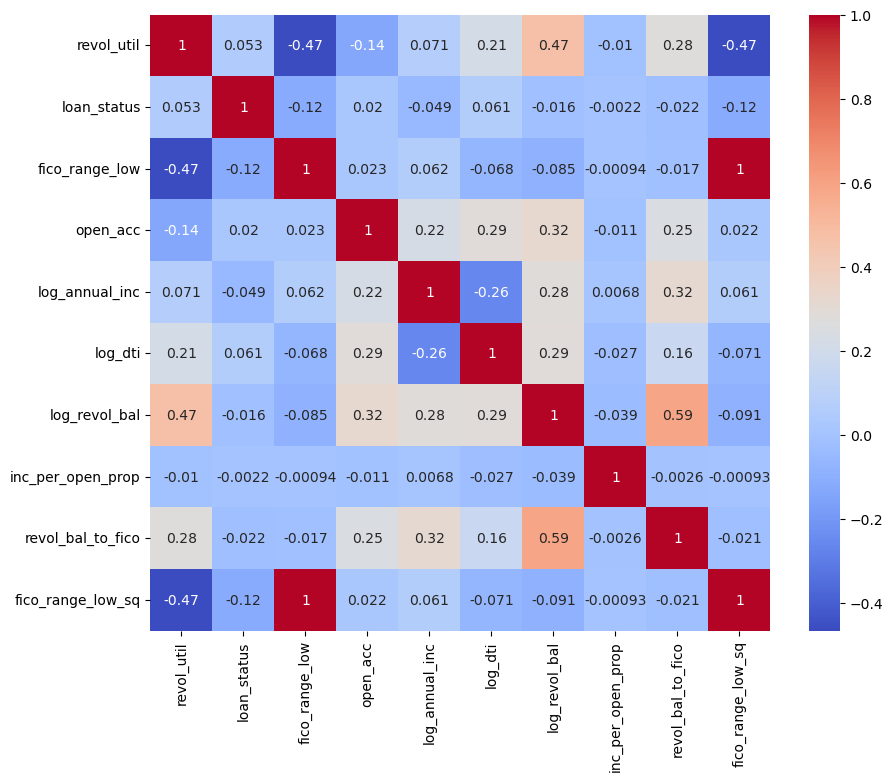

In [31]:
# Re-examine the correlations
heatmap = plot_correlation_heatmap(imputed_df)
heatmap

In [32]:
# View sorted correlations
correlation_df = sorted_correlation_dataframe(imputed_df)
correlation_df

Variable 1         Variable 2  Correlation
10     fico_range_low  fico_range_low_sq     0.999495
11  fico_range_low_sq     fico_range_low     0.999495
12      log_revol_bal  revol_bal_to_fico     0.591311
13  revol_bal_to_fico      log_revol_bal     0.591311
14      log_revol_bal         revol_util     0.471789
15         revol_util      log_revol_bal     0.471789
16  fico_range_low_sq         revol_util    -0.466619
17         revol_util  fico_range_low_sq    -0.466619
18     fico_range_low         revol_util    -0.465072
19         revol_util     fico_range_low    -0.465072
20           open_acc      log_revol_bal     0.323766
21      log_revol_bal           open_acc     0.323766
22  revol_bal_to_fico     log_annual_inc     0.315738
23     log_annual_inc  revol_bal_to_fico     0.315738
24            log_dti           open_acc     0.288753
25           open_acc            log_dti     0.288753
26      log_revol_bal            log_dti     0.288391
27            log_dti      log_revol_bal     0.288391
28     log_annual_inc      log_revol_bal     0.283639
29      log_revol_bal     log_annual_inc     0.283639
30         revol_util  revol_bal_to_fico     0.278055
31  revol_bal_to_fico         revol_util     0.278055
32            log_dti     log_annual_inc    -0.263024
33     log_annual_inc            log_dti    -0.263024
34           open_acc  revol_bal_to_fico     0.245530
35  revol_bal_to_fico           open_acc     0.245530
36           open_acc     log_annual_inc     0.224872
37     log_annual_inc           open_acc     0.224872
38         revol_util            log_dti     0.211547
39            log_dti         revol_util     0.211547
40  revol_bal_to_fico            log_dti     0.163215
41            log_dti  revol_bal_to_fico     0.163215
42         revol_util           open_acc    -0.135262
43           open_acc         revol_util    -0.135262
44        loan_status     fico_range_low    -0.121300
45     fico_range_low        loan_status    -0.121300
46  fico_range_low_sq        loan_status    -0.120328
47        loan_status  fico_range_low_sq    -0.120328
48  fico_range_low_sq      log_revol_bal    -0.090584
49      log_revol_bal  fico_range_low_sq    -0.090584
50     fico_range_low      log_revol_bal    -0.085349
51      log_revol_bal     fico_range_low    -0.085349
52  fico_range_low_sq            log_dti    -0.071310
53            log_dti  fico_range_low_sq    -0.071310
54     log_annual_inc         revol_util     0.071136
55         revol_util     log_annual_inc     0.071136
56     fico_range_low            log_dti    -0.068428
57            log_dti     fico_range_low    -0.068428
58     log_annual_inc     fico_range_low     0.062004
59     fico_range_low     log_annual_inc     0.062004
60            log_dti        loan_status     0.061315
61        loan_status            log_dti     0.061315
62     log_annual_inc  fico_range_low_sq     0.061203
63  fico_range_low_sq     log_annual_inc     0.061203
64        loan_status         revol_util     0.052535
65         revol_util        loan_status     0.052535
66        loan_status     log_annual_inc    -0.048694
67     log_annual_inc        loan_status    -0.048694
68      log_revol_bal  inc_per_open_prop    -0.038754
69  inc_per_open_prop      log_revol_bal    -0.038754
70            log_dti  inc_per_open_prop    -0.027024
71  inc_per_open_prop            log_dti    -0.027024
72     fico_range_low           open_acc     0.022983
73           open_acc     fico_range_low     0.022983
74  fico_range_low_sq           open_acc     0.022052
75           open_acc  fico_range_low_sq     0.022052
76        loan_status  revol_bal_to_fico    -0.022014
77  revol_bal_to_fico        loan_status    -0.022014
78  revol_bal_to_fico  fico_range_low_sq    -0.020533
79  fico_range_low_sq  revol_bal_to_fico    -0.020533
80        loan_status           open_acc     0.019891
81           open_acc        loan_status     0.019891
82  revol_bal_to_fico     fico_range_low    -0.017230
83     fico_ran

## New Feature Analysis
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this section, we created new features that we believe will be useful in the upcoming modeling process. Let's discuss each of these new features in further detail. Firstly, we applied log transformations to the features that possessed highly skewed distributions (skewness value greater than 5). Transforming the features in this way may help to reduce the impact of noise/outliers, which decision tree models can be highly sensitive to.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The next feature that we created, "inc_per_open_prop", represents the annual income of an individual divided by the proportion of open accounts that they possess. If this value is high, then the borrower has a high annual income relative to the proportion of their open accounts. Someone with a high proportion of open accounts and a lower income may be more at risk for default then someone with the same proportion of open accounts and a higher income.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Another feature that we engineered is "revol_bal_to_fico", which represents the borrower's credit revolving balance relative to their creditworthiness. A higher value on this feature would indicate that a borrower has a large amount of revolving credit relative to their credit score. This could potentially suggest a higher risk for default.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lastly, we created a polynomial feature "fico_range_low_sq" by squaring the low range credit score. We showed preference to the low range credit score as opposed to the high range credit score because we wished to be slightly more conservative in measuring borrower creditworthiness. This polynomial feature may allow us to capture a non-linear, U-shaped relationship between credit score and loan default. Perhaps borrowers with either very low or very high credit scores are more at risk for default. This could be the case for borrowers with very low credit scores due to inability to meet financial obligations and for borrowers with very high credit scores due to a tendency to overextend themselves with their highly accessible credit.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After creating the new features, we removed the redundant features ("fico_range_high" and "total_acc") and the original features that were subjected to log transformations. We then re-examined the correlations between all of the features in our updated dataset. As expected, the polynomial feature was very strongly correlated with the variable it was derived from. We also noticed that there are a higher number of moderately strong associations between variables post-feature-engineering and variable reduction. There is a good mix of both positive and negative correlations among these moderately strong relationships.

## Part 6: Predictive Modeling

In [33]:
# Check if oversampling will be needed
target_class_percentage = round((imputed_df['loan_status'].value_counts()[1]/imputed_df['loan_status'].value_counts()[0]) * 100, 2)

print(f'Target Class Percentage: {target_class_percentage}%')

Target Class Percentage: 13.97%


Our class of interest (loan default = 1) accounts for approximately 14% of the dataset. This indicates that we have a class imbalance present. We decided to address the class imbalance via oversampling. This can be observed after the data is partitioned.

In [34]:
# Create feature and label variables
features = imputed_df.drop(columns='loan_status')
label = imputed_df['loan_status']

X = features
y = label

In [35]:
# Partition the data into training (50%), validation (30%), and test (20%) 
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.5, random_state=0)

valid_X, test_X, valid_y, test_y = train_test_split(temp_X, temp_y, test_size=0.4, random_state=0)

print('Training Set:   ', train_X.shape)
print('Validation Set: ', valid_X.shape)
print('Test Set:       ', test_X.shape)

Training Set:    (52429, 9)
Validation Set:  (31457, 9)
Test Set:        (20972, 9)


In [36]:
# Oversampling due to imbalanced classes
smote = SMOTE(random_state=1)

train_X, train_y = smote.fit_resample(train_X, train_y)

In [37]:
# Scaling the data
feature_names = train_X.columns # Storing for later

scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

In general, scaling the data is much more important for linear regression models where weights with larger scales can have undue influence on the model and subsequent results. Decision tree classifiers are not sensitive to feature scales since they are based on the rank-ordering of feature values instead of the calculation of weights. Therefore, scaling is not really necessary with these types of models. Nevertheless, we decided to implement it here since doing so will likely have no negative effect on the performance of the model in any case.

In [38]:
# Instantiate a decision tree classification model
class_tree = DecisionTreeClassifier(max_depth=5, random_state=1)

# Fit the model to the training data
class_tree.fit(train_X, train_y)

# Store predictions
pred_train = class_tree.predict(train_X)
pred_valid = class_tree.predict(valid_X)
pred_test = class_tree.predict(test_X)

pred_train_proba = class_tree.predict_proba(train_X)[:,1]
pred_valid_proba = class_tree.predict_proba(valid_X)[:,1]
pred_test_proba = class_tree.predict_proba(test_X)[:,1]

Tree has 53 nodes


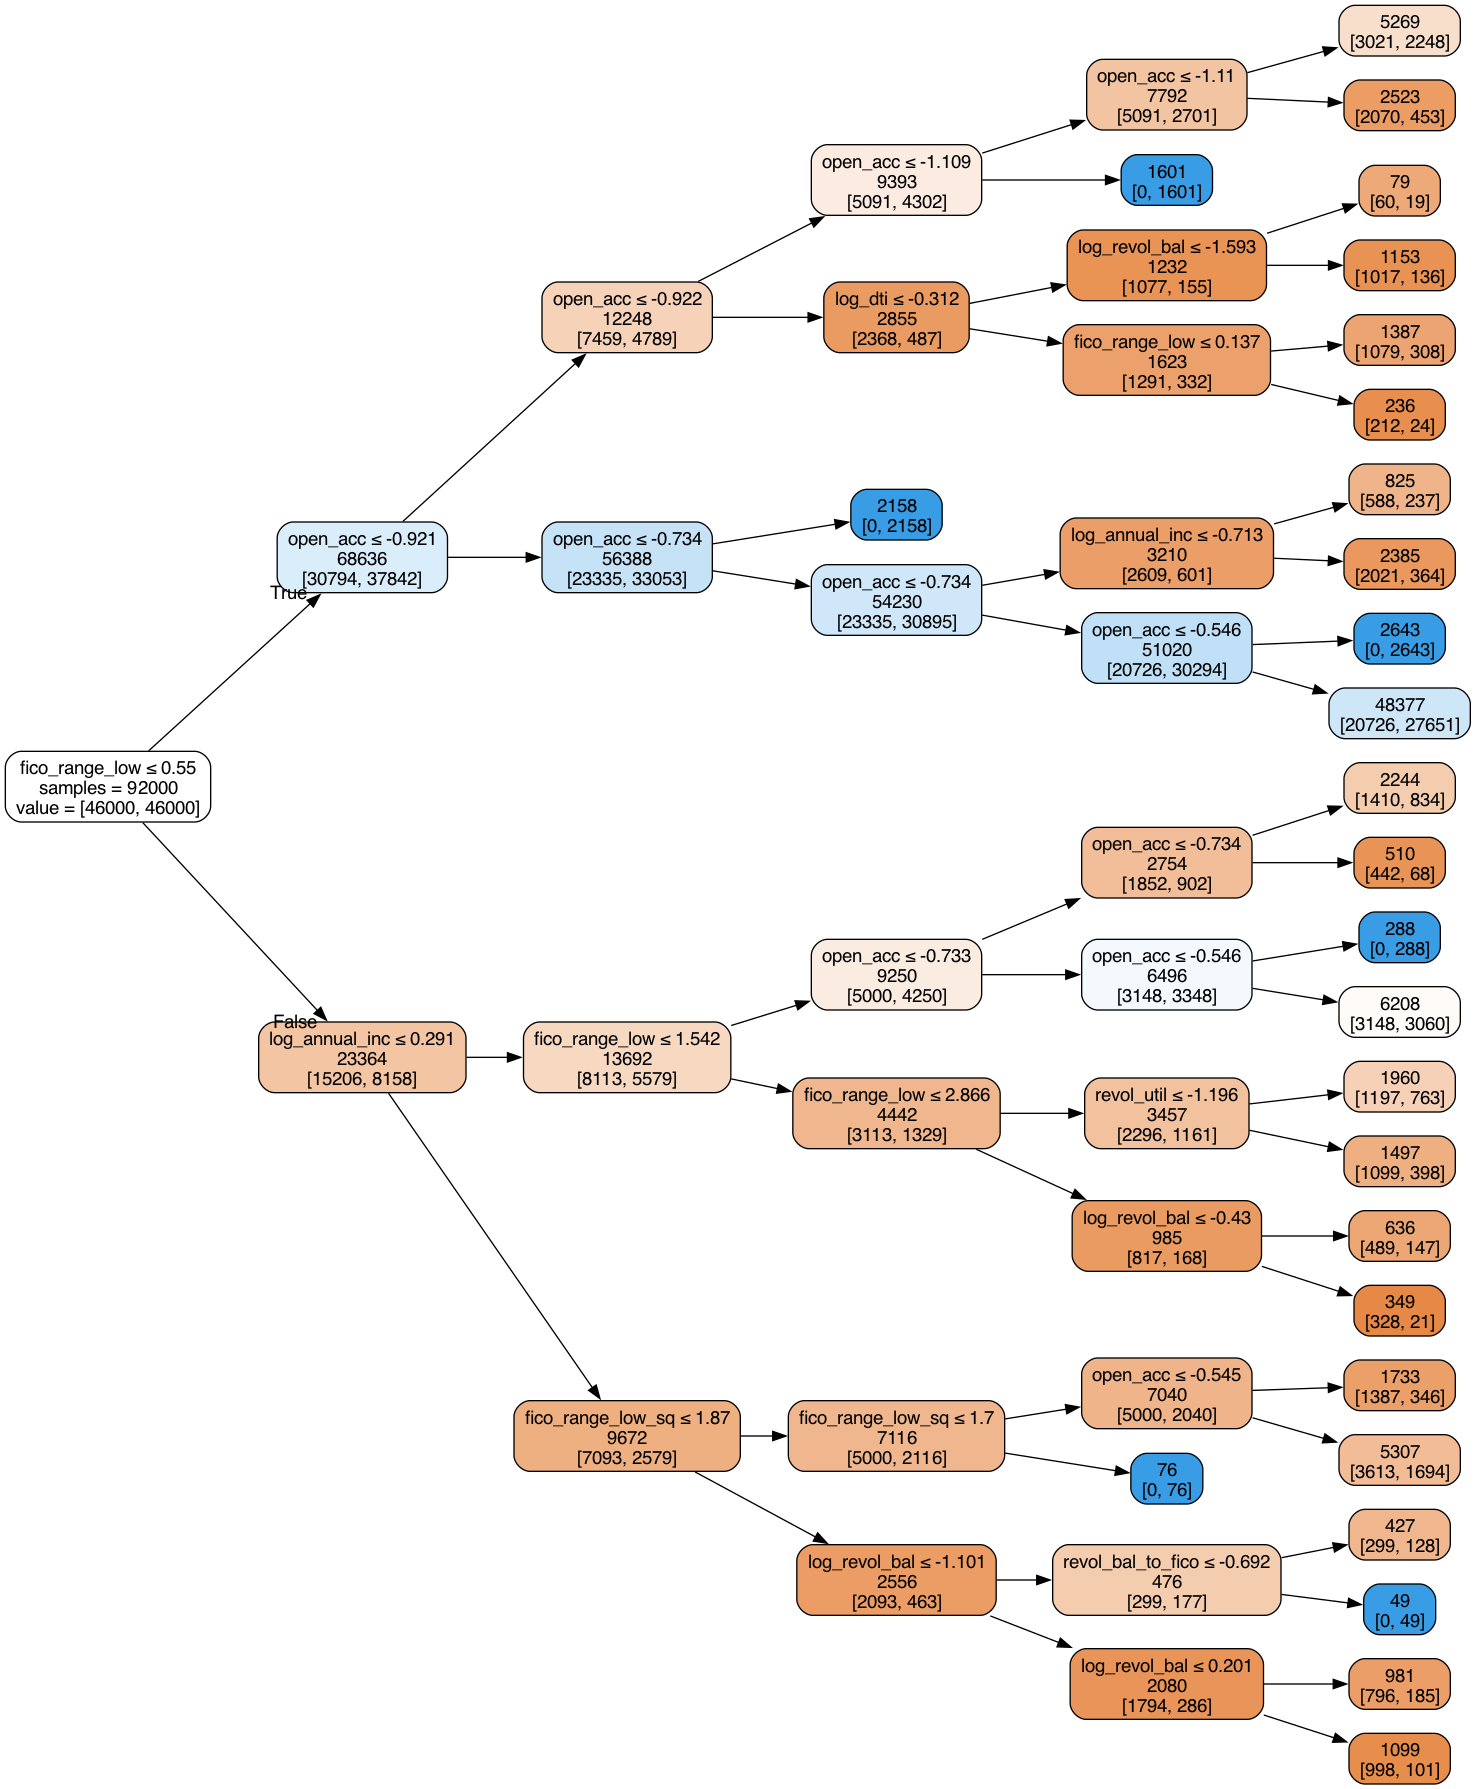

In [39]:
# Plot the tree
print('Tree has {} nodes'.format(class_tree.tree_.node_count))

plotDecisionTree(class_tree, feature_names=features.columns, rotate=True)

In [40]:
# Feature importance for classification tree
def feature_importance_table(model):
    importanceCT = pd.DataFrame({
        'Features': features.columns, 
        'Importance': model.feature_importances_
        })
    
    importanceCT = importanceCT.sort_values(by=['Importance'], ascending=False)
    
    return importanceCT

importance_table = feature_importance_table(class_tree)
importance_table

Features  Importance
2           open_acc    0.720083
1     fico_range_low    0.212219
3     log_annual_inc    0.032224
8  fico_range_low_sq    0.016522
5      log_revol_bal    0.008822
7  revol_bal_to_fico    0.005623
0         revol_util    0.003373
4            log_dti    0.001133
6  inc_per_open_prop    0.000000

In [41]:
# View confusion matrix - Training set
classificationSummary(train_y, class_tree.predict(train_X))

Confusion Matrix (Accuracy 0.6493)

       Prediction
Actual     0     1
     0 25274 20726
     1 11534 34466


In [42]:
# View confusion matrix - Validation set
classificationSummary(valid_y, class_tree.predict(valid_X))

Confusion Matrix (Accuracy 0.5578)

       Prediction
Actual     0     1
     0 15330 12281
     1  1630  2216


In [43]:
# View confusion matrix - Test set
classificationSummary(test_y, class_tree.predict(test_X))

Confusion Matrix (Accuracy 0.5521)

       Prediction
Actual     0     1
     0 10093  8303
     1  1090  1486


In [44]:
# Evaluation metrics - Training set
def print_metrics_for_model(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # For specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)

    # Print metrics
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('Specificity: {:.2f}'.format(specificity))
    print('ROC AUC: {:.2f}'.format(roc_auc))

metrics_train = print_metrics_for_model(train_y, pred_train, pred_train_proba)
metrics_train

Accuracy: 0.65
Precision: 0.62
Recall: 0.75
Specificity: 0.55
ROC AUC: 0.71


In [45]:
# Evaluation metrics - Validation set
metrics_valid = print_metrics_for_model(valid_y, pred_valid, pred_valid_proba)
metrics_valid

Accuracy: 0.56
Precision: 0.15
Recall: 0.58
Specificity: 0.56
ROC AUC: 0.57


In [46]:
# Evaluation metrics - Test set
metrics_test = print_metrics_for_model(test_y, pred_test, pred_test_proba)
metrics_test

Accuracy: 0.55
Precision: 0.15
Recall: 0.58
Specificity: 0.55
ROC AUC: 0.57


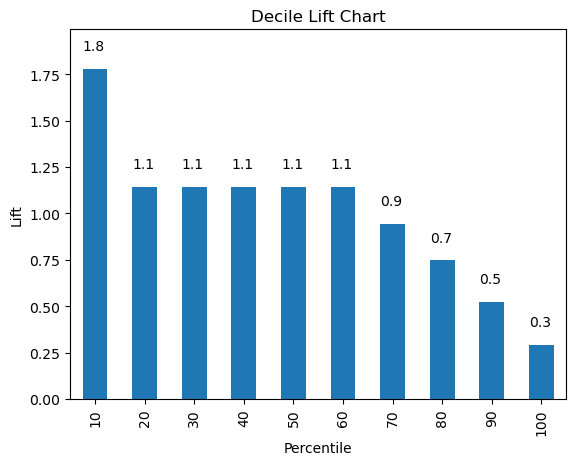

In [47]:
# Lift chart - Training set
def plot_lift_chart(model, partition_X, partition_y):
    proba = model.predict_proba(partition_X)
    
    result = pd.DataFrame({
        'Actual': partition_y,
        'p(0)': [p[0] for p in proba],
        'p(1)': [p[1] for p in proba],
        'Predicted': model.predict(partition_X)
    })
    
    df = result.sort_values(by=['p(1)'], ascending=False)
    
    liftChart(df['p(1)'], title='Decile Lift Chart')
    plt.show()
    
lift_chart_train = plot_lift_chart(class_tree, train_X, train_y)
lift_chart_train

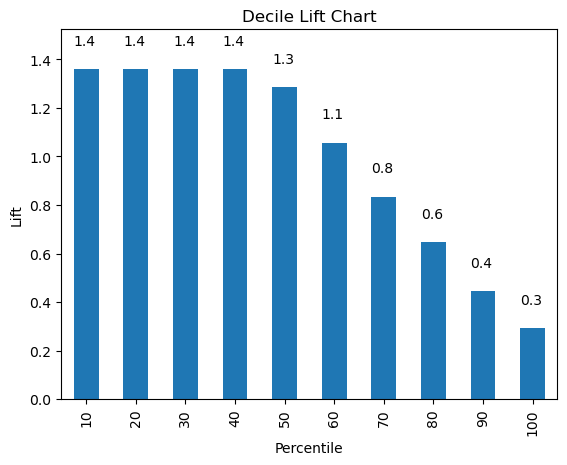

In [48]:
# Lift chart - Validation set    
lift_chart_valid = plot_lift_chart(class_tree, valid_X, valid_y)
lift_chart_valid

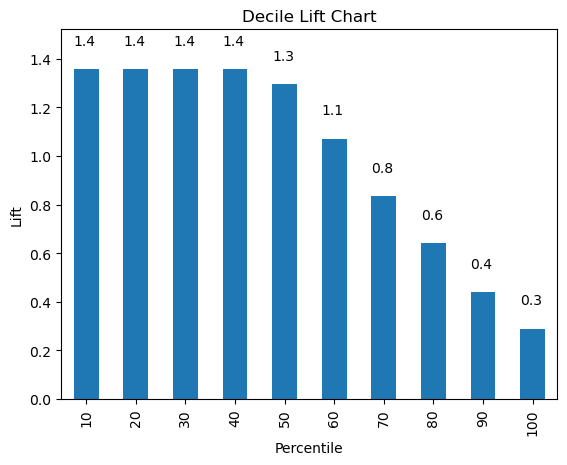

In [49]:
# Lift chart - Test set
lift_chart_test = plot_lift_chart(class_tree, test_X, test_y)
lift_chart_test

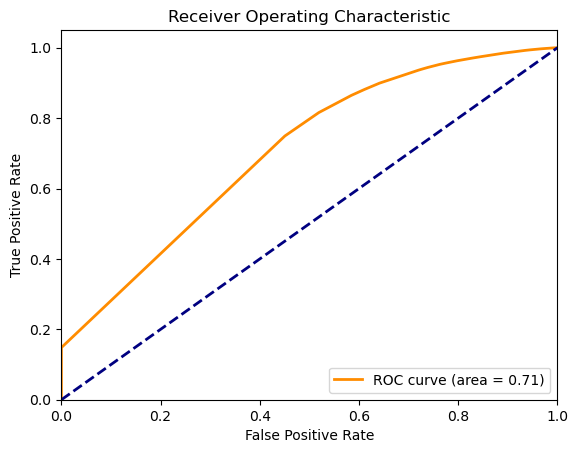

In [50]:
# Plot ROC Curve - Training set
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
roc_curve_train = plot_roc_curve(train_y, pred_train_proba)
roc_curve_train

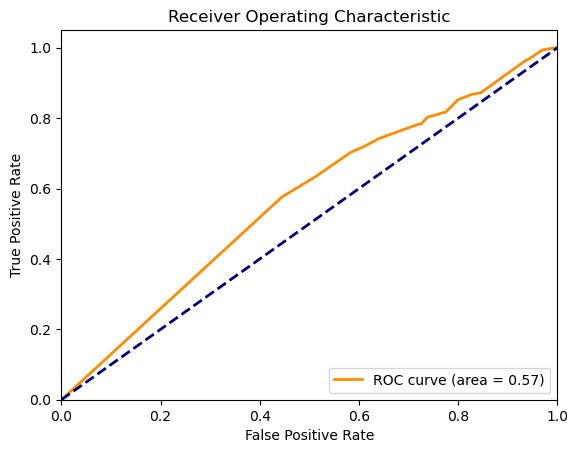

In [51]:
# Plot ROC Curve - Validation set
roc_curve_valid = plot_roc_curve(valid_y, pred_valid_proba)
roc_curve_valid

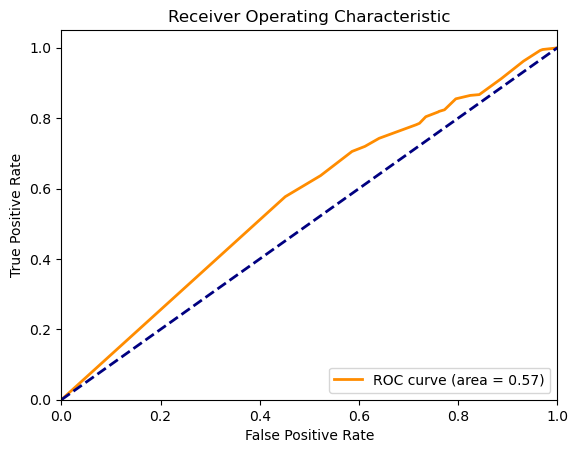

In [52]:
# Plot ROC Curve - Test set
roc_curve_test = plot_roc_curve(test_y, pred_test_proba)
roc_curve_test

## Model Evaluation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The decision tree classifier was run with a max_depth parameter of 5. The most useful features for splitting decisions were "open_acc" (0.72) and "fico_range_low" (0.21). The feature "inc_per_open_prop" was not useful for splitting decision as evidenced by its importance value of 0.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model was 65% accurate on the training partition, 56% accurate on the validation partition, and 55% accurate on the test partition. This discrepancy is indicative of overfitting to the training data. Precision dropped markedly from 62% on the training set to 15% on the validation and test sets. The model cannot reliably identify actual positives on new data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Recall dropped from 75% to 58%, indicating the model is less effective at identifying all the actual positive instances when faced with unseen data. Specificity was maintained at around 55% across all partitions. The model's ability to correctly identify all the actual negatives is consistent across partitions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The ROC-AUC score decreased from 71% to 57%. Moreover, the ROC chart illustrates the curve following the diagonal line more closely for the validation and test sets. This suggests that the model's ability to distinguish between the two classes has degraded across partitions. The decile lift charts show that the model performs better than random selection at identifying instances of the target class for the records that have been assigned the highest probability of belonging to the target class. The model's target class identification ability declines below random selection for records that have been assigned a low probability of belonging to the target class.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the metrics and graphical results described above, the model has likely overfit to the training data. It has displayed poor generalization performance on the validation and test partitions. Perhaps the model could be improved by leveraging grid search for hyperparameter optimization and cross validation methods. We will explore this possibility below.

In [53]:
# Run an optimized classification tree with GridSearchCV
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50]
    }

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    'min_samples_split': [8, 9, 10, 11, 12, 13]
    }

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

opt_class_tree = gridSearch.best_estimator_
importanceCT = pd.DataFrame({
    'Features': features.columns, 
    'Importance': opt_class_tree.feature_importances_
    })

Initial parameters:  {'max_depth': 25, 'min_impurity_decrease': 0, 'min_samples_split': 50}
Improved parameters:  {'max_depth': 8, 'min_impurity_decrease': 0, 'min_samples_split': 8}


In [54]:
# Store predictions
pred_train = opt_class_tree.predict(train_X)
pred_valid = opt_class_tree.predict(valid_X)
pred_test = opt_class_tree.predict(test_X)

pred_train_proba = opt_class_tree.predict_proba(train_X)[:,1]
pred_valid_proba = opt_class_tree.predict_proba(valid_X)[:,1]
pred_test_proba = opt_class_tree.predict_proba(test_X)[:,1]

Tree has 285 nodes


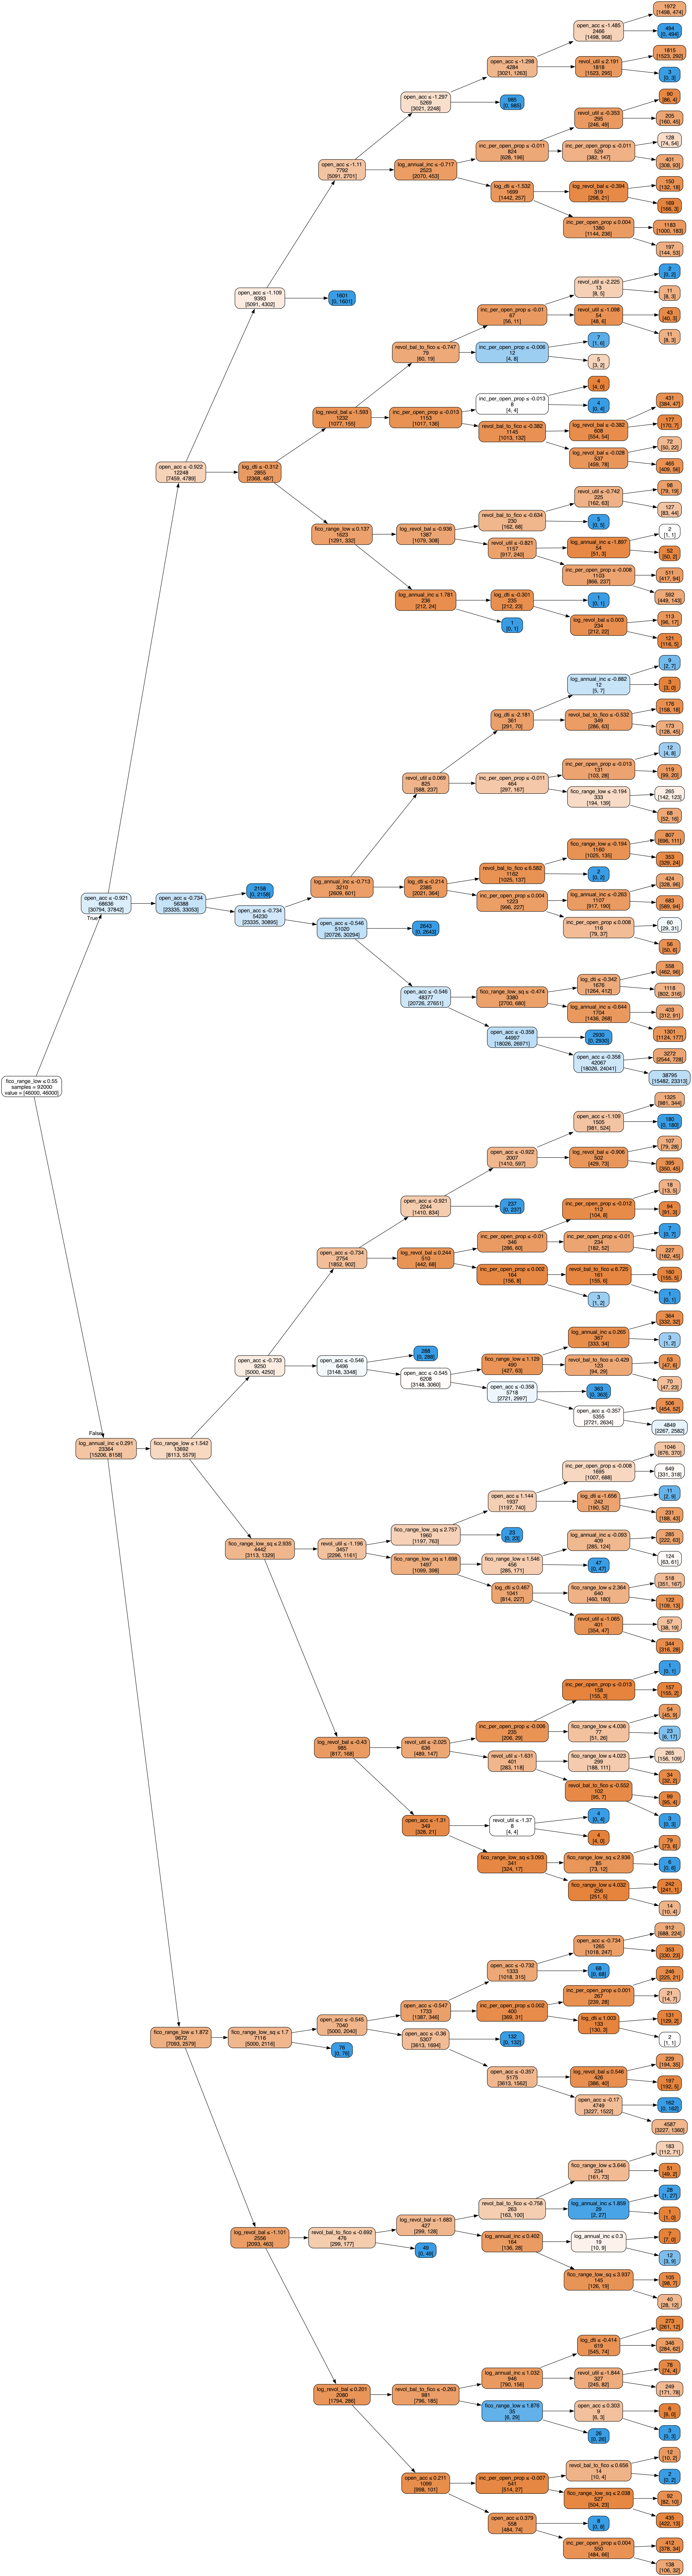

In [55]:
# Plot the tree
print('Tree has {} nodes'.format(opt_class_tree.tree_.node_count))

plotDecisionTree(opt_class_tree, feature_names=features.columns, rotate=True)

In [56]:
# New feature importance table
feature_importance_table(opt_class_tree)

Features  Importance
2           open_acc    0.804546
1     fico_range_low    0.125360
3     log_annual_inc    0.021865
8  fico_range_low_sq    0.012979
7  revol_bal_to_fico    0.009004
6  inc_per_open_prop    0.007814
5      log_revol_bal    0.007130
0         revol_util    0.006779
4            log_dti    0.004524

In [57]:
# Error reports for training, validation, and test sets
print('Training Set:')
classificationSummary(train_y, opt_class_tree.predict(train_X))

print('\nValidation Set:')
classificationSummary(valid_y, opt_class_tree.predict(valid_X))

print('\nTest Set:')
classificationSummary(test_y, opt_class_tree.predict(test_X))

Training Set:
Confusion Matrix (Accuracy 0.7253)

       Prediction
Actual     0     1
     0 28201 17799
     1  7472 38528

Validation Set:
Confusion Matrix (Accuracy 0.5980)

       Prediction
Actual     0     1
     0 16953 10658
     1  1989  1857

Test Set:
Confusion Matrix (Accuracy 0.5907)

       Prediction
Actual     0     1
     0 11100  7296
     1  1287  1289


In [58]:
# New metrics report - Training
print_metrics_for_model(train_y, pred_train, pred_train_proba)

Accuracy: 0.73
Precision: 0.68
Recall: 0.84
Specificity: 0.61
ROC AUC: 0.80


In [59]:
# New metrics report - Validation
print_metrics_for_model(valid_y, pred_valid, pred_valid_proba)

Accuracy: 0.60
Precision: 0.15
Recall: 0.48
Specificity: 0.61
ROC AUC: 0.55


In [60]:
# New metrics report - Test
print_metrics_for_model(test_y, pred_test, pred_test_proba)

Accuracy: 0.59
Precision: 0.15
Recall: 0.50
Specificity: 0.60
ROC AUC: 0.56


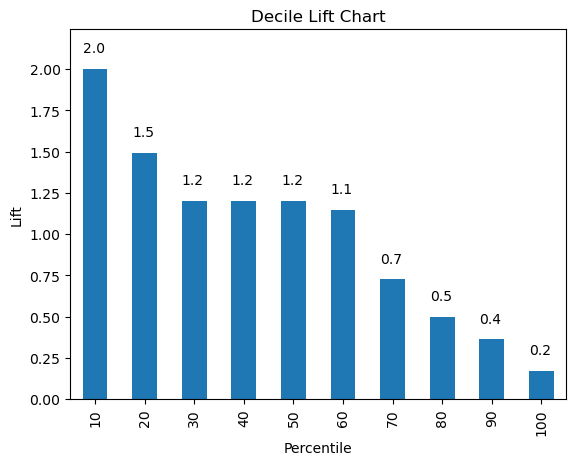

In [61]:
# New lift chart - Training
plot_lift_chart(opt_class_tree, train_X, train_y)

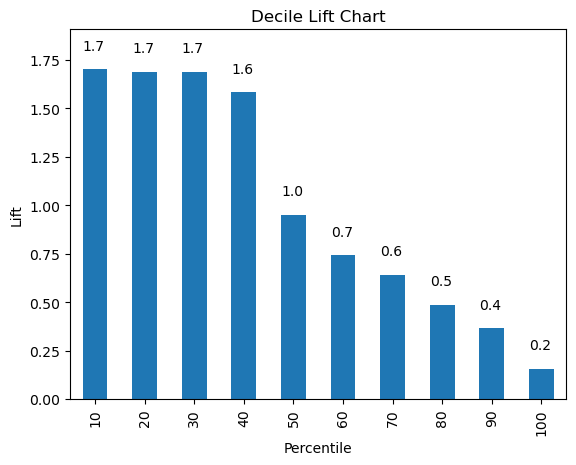

In [62]:
# New lift chart - Validation
plot_lift_chart(opt_class_tree, valid_X, valid_y)

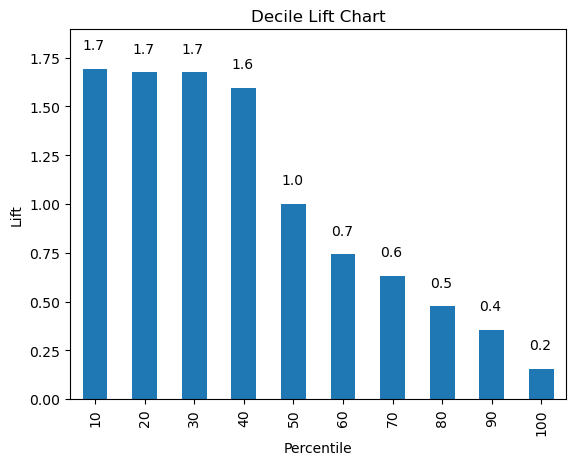

In [63]:
# New lift chart - Test
plot_lift_chart(opt_class_tree, test_X, test_y)

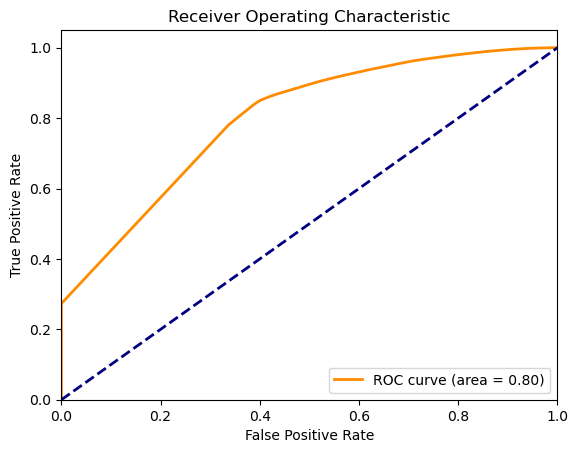

In [64]:
# New ROC curve plot - Training
plot_roc_curve(train_y, pred_train_proba)

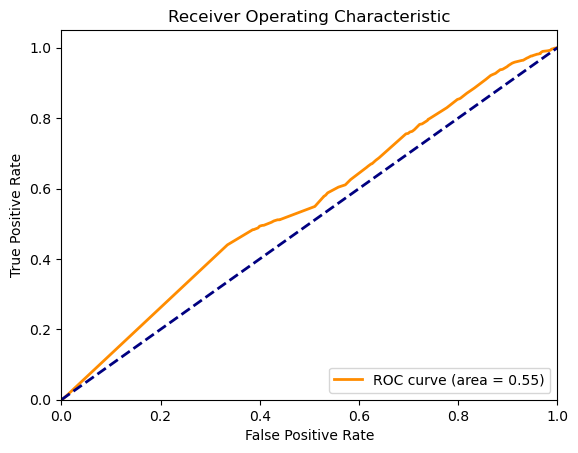

In [65]:
# New ROC curve plot - Validation
plot_roc_curve(valid_y, pred_valid_proba)

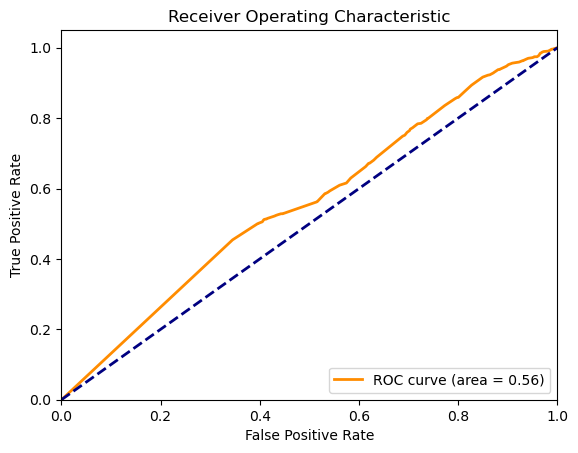

In [66]:
# New ROC curve plot - Test
plot_roc_curve(test_y, pred_test_proba)

## Model Evaluation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The decision tree classifier was run with GridSearchCV to find optimal hyperparameters. The hyperparameters that the model utilized were: max_depth of 8, min_impurity_decrease of 0, and min_samples_split of 8. The most useful features for splitting decisions were "open_acc" (0.80) and "fico_range_low" (0.13).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model was 73% accurate on the training partition, 60% accurate on the validation partition, and 59% accurate on the test partition. This large change in accuracy suggests that the model has been overfit to the training data. Precision dropped even more than in the previous model, from 68% on the training set to 15% on the validation and test sets. The model cannot reliably identify actual positives on new data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Recall decreased to an even lower score than with the previous model, from 84% to 48% and 50%. The model is less effective at identifying all the actual positive instances for new data. Specificity was maintained at around 61% across all partitions. Similar to the last model, the new model's ability to correctly identify all the actual negatives is consistent across partitions.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The ROC-AUC score decreased from 80% to 55% and 56%. As shown in the ROC chart, the curve follows the diagonal line closely for the validation and test sets. This indicates that the model is not as effective at distinguishing between classes on unseen data. The decile lift charts show that the new model performs even better than the last model at identifying the target class for the instances that have been assigned the highest probability of belonging to the target class. However, the model's performance on the data with the lowest probability of target class membership is worse than with the previous model.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In conclusion, the model produced with GridSearchCV did not perform significantly better than the original model, and in many ways its performance was arguably weaker. This poor performance is likely due to the new model being even more overfit to the training data than the previous, shallower model. In the following section, we will run a random forest classifier with RandomizedSearchCV for hyperparameter optimization. Perhaps this ensembling approach will yield a model that is more performant than the previous two.

In [67]:
# Run an optimized random forest classifier with RandomizedSearchCV
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50],
    'n_estimators': [10, 50, 100, 150, 200]
    }

randomSearch = RandomizedSearchCV(RandomForestClassifier(random_state=1), param_grid, n_iter=50, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    randomSearch.fit(train_X, train_y)
print('Initial parameters: ', randomSearch.best_params_)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    'min_samples_split': [8, 9, 10, 11, 12, 13],
    'n_estimators': [130, 140, 150, 160, 170]
    }

randomSearch = RandomizedSearchCV(RandomForestClassifier(random_state=1), param_grid, n_iter=50, cv=5, n_jobs=-1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    randomSearch.fit(train_X, train_y)
print('Improved parameters: ', randomSearch.best_params_)

random_forest_clf = randomSearch.best_estimator_
importanceRF = pd.DataFrame({
    'Features': features.columns, 
    'Importance': random_forest_clf.feature_importances_
    })

Initial parameters:  {'n_estimators': 200, 'min_samples_split': 10, 'min_impurity_decrease': 0, 'max_depth': 20}
Improved parameters:  {'n_estimators': 140, 'min_samples_split': 11, 'min_impurity_decrease': 0, 'max_depth': 8}


In [68]:
# Store predictions
pred_train = random_forest_clf.predict(train_X)
pred_valid = random_forest_clf.predict(valid_X)
pred_test = random_forest_clf.predict(test_X)

pred_train_proba = random_forest_clf.predict_proba(train_X)[:,1]
pred_valid_proba = random_forest_clf.predict_proba(valid_X)[:,1]
pred_test_proba = random_forest_clf.predict_proba(test_X)[:,1]

Tree has 363 nodes


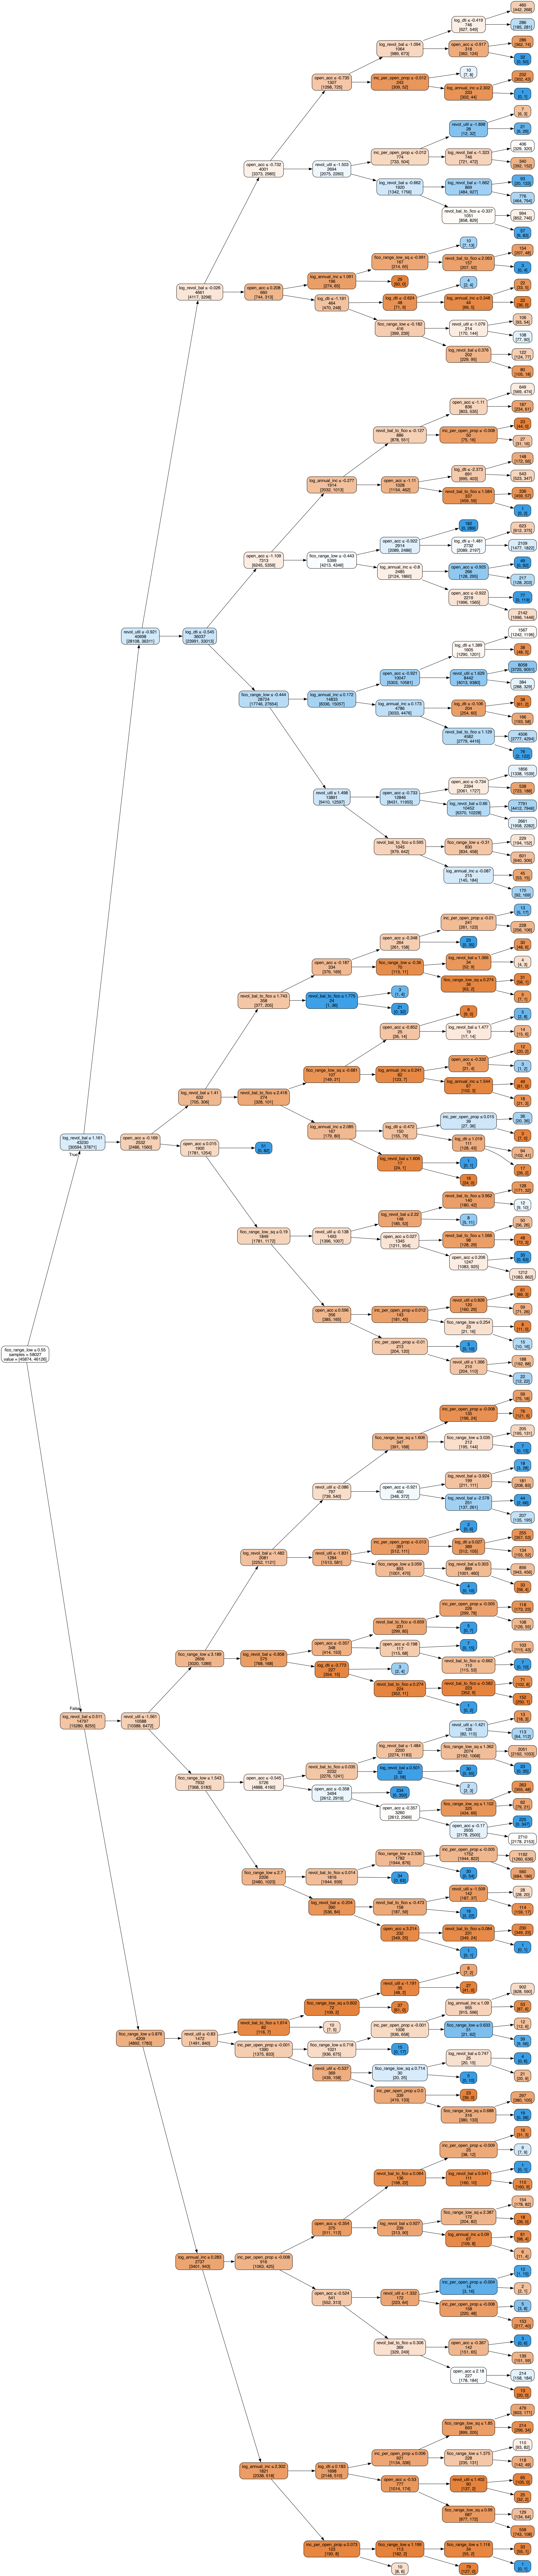

In [69]:
# Plot the first tree
print('Tree has {} nodes'.format(random_forest_clf.estimators_[0].tree_.node_count))

plotDecisionTree(random_forest_clf.estimators_[0], feature_names=features.columns, rotate=True)

In [70]:
# New feature importance table
feature_importance_table(random_forest_clf)

Features  Importance
2           open_acc    0.397710
1     fico_range_low    0.125883
8  fico_range_low_sq    0.118816
5      log_revol_bal    0.081292
3     log_annual_inc    0.072200
0         revol_util    0.062261
4            log_dti    0.059511
7  revol_bal_to_fico    0.055859
6  inc_per_open_prop    0.026467

In [71]:
# Error reports for training, validation, and test sets
print('Training Set:')
classificationSummary(train_y, random_forest_clf.predict(train_X))

print('\nValidation Set:')
classificationSummary(valid_y, random_forest_clf.predict(valid_X))

print('\nTest Set:')
classificationSummary(test_y, random_forest_clf.predict(test_X))

Training Set:
Confusion Matrix (Accuracy 0.7251)

       Prediction
Actual     0     1
     0 30576 15424
     1  9865 36135

Validation Set:
Confusion Matrix (Accuracy 0.6380)

       Prediction
Actual     0     1
     0 18198  9413
     1  1974  1872

Test Set:
Confusion Matrix (Accuracy 0.6351)

       Prediction
Actual     0     1
     0 12105  6291
     1  1361  1215


In [72]:
# New metrics report - Training
print_metrics_for_model(train_y, pred_train, pred_train_proba)

Accuracy: 0.73
Precision: 0.70
Recall: 0.79
Specificity: 0.66
ROC AUC: 0.80


In [73]:
# New metrics report - Validation
print_metrics_for_model(valid_y, pred_valid, pred_valid_proba)

Accuracy: 0.64
Precision: 0.17
Recall: 0.49
Specificity: 0.66
ROC AUC: 0.61


In [74]:
# New metrics report - Test
print_metrics_for_model(test_y, pred_test, pred_test_proba)

Accuracy: 0.64
Precision: 0.16
Recall: 0.47
Specificity: 0.66
ROC AUC: 0.61


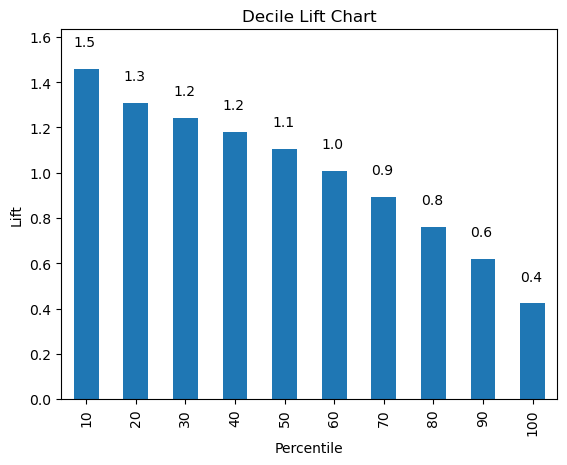

In [75]:
# New lift chart - Training
plot_lift_chart(random_forest_clf, train_X, train_y)

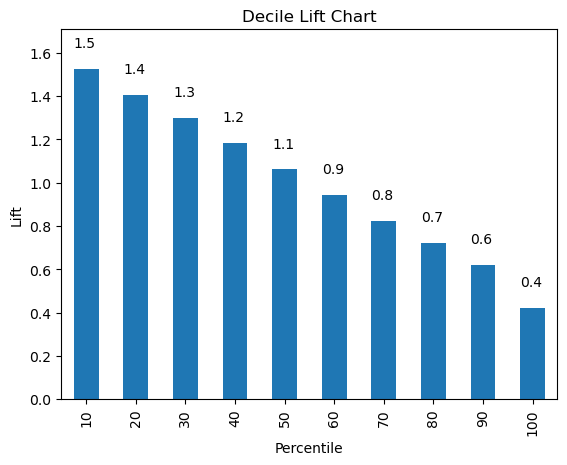

In [76]:
# New lift chart - Validation
plot_lift_chart(random_forest_clf, valid_X, valid_y)

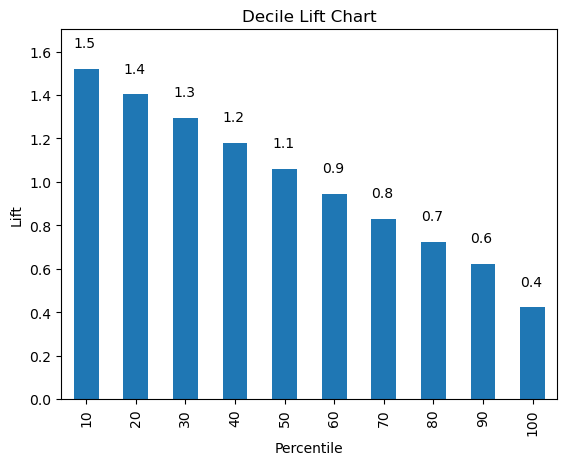

In [77]:
# New lift chart - Test
plot_lift_chart(random_forest_clf, test_X, test_y)

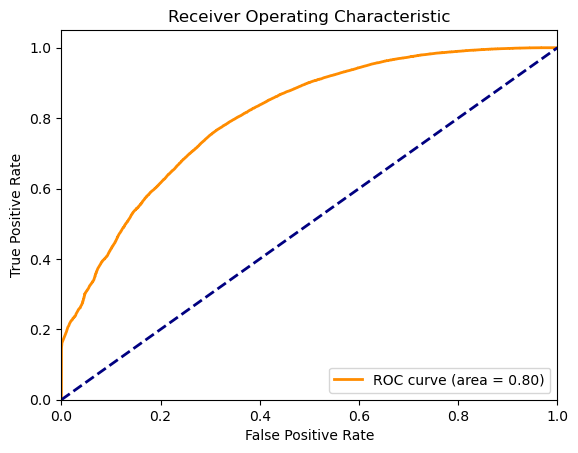

In [78]:
# New ROC curve plot - Training
plot_roc_curve(train_y, pred_train_proba)

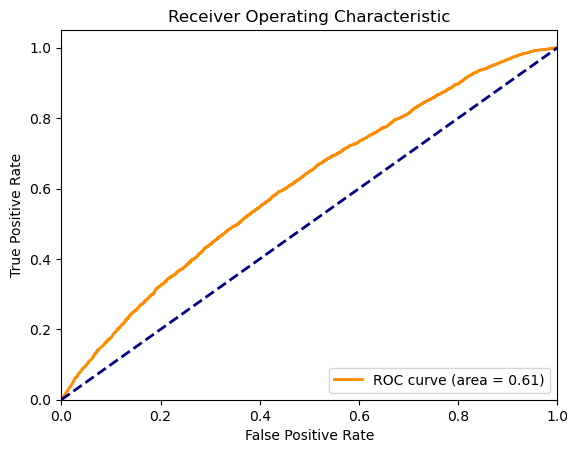

In [79]:
# New ROC curve plot - Validation
plot_roc_curve(valid_y, pred_valid_proba)

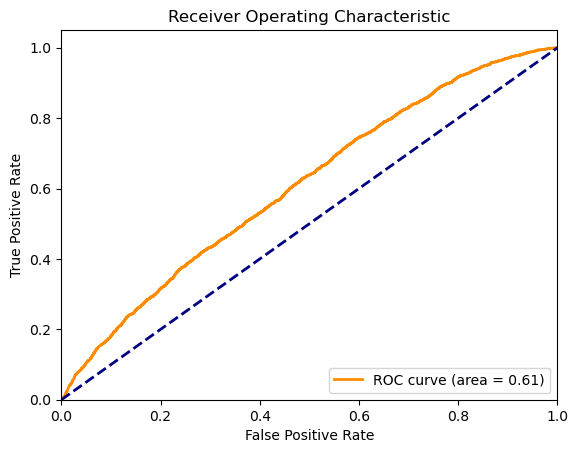

In [80]:
# New ROC curve plot - Test
plot_roc_curve(test_y, pred_test_proba)

## Model Evaluation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The random forest classifier was run with RandomizedSearchCV to find optimal hyperparameters. RandomizedSearchCV was used instead of GridSearchCV to alleviate, however slightly, the computational burden of creating a random forest classifier with optimized hyperparameters. GridSearchCV uses a more exhaustive approach of computing every possible combination of the hyperparameters. This approach would likely have been too time-consuming. The hyperparameters that the model utilized were: n_estimators of 140, min_samples_split of 11, min_impurity_decrease of 0, and max_depth of 8. The most useful features for splitting decisions were "open_acc" (0.40), "fico_range_low" (0.13), and "fico_range_low_sq" (0.12). The random forest model appears to rely less on the "open_acc" feature than the previous models.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model was 73% accurate on the training partition, 64% accurate on the validation partition, and 64% accurate on the test partition. The change in accuracy across partitions is narrowly less pronounced than in the previous model. We have traded high accuracy on the training set for slightly greater generalizability on the validation and test sets. Precision degraded at levels comparable to the other models, from 70% on the training set to 17% and 16%. All of the models predicted way more target class instances than there actually were.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Recall decreased from 79% to 49% and 47%. On unseen data, the random forest model identifies all actual positives at a rate comparable to the last model. Specificity was again maintained across all partitions (66%). All of the models have displayed consistency across partitions with respect to their ability to detect all actual negatives.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The ROC-AUC score decreased from 80% to 61%. The ROC chart shows that the curved line gets closer to the diagonal line for the validation and test sets. However, there is more separation between the two lines than in the last two models. So while the model's ability to discriminate between classes diminishes on novel data, it does perform better than the previous two models. The decile lift charts show a gradual decrease in predictive performance across the ranked propensities and the lift values are more evenly distributed than in the other models. In other words, the new model performs more consistently across the the different propensity levels.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall, the results of the random forest classifier were mildly encouraging. One aspect of the model that was certainly better was that it appeared to be less overfitted than the other models. In addition, slight improvements on the evaluation metrics were observed. Even small increases in performance can be significant when it comes to high-stakes situations like loan default and lending decisions. A disadvantage of the optimized random forest classifer we created is that it is computationally expensive and therefore time-consuming to run.

## Conclusion
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After creating three different decision-tree classification models and evaluating their performance, we believe that the optimized random forest model is the best model to adopt. It displayed modest performance improvements and exhibited greater generalization potential than both the shallow tree model and the optimized tree model. This result highlights the power of ensembling methods, where predictions are aggregated across multiple models to reduce the variation in prediction errors. This ultimately enables ensemble-based models to produce more accurate predictions, on average. The random forest classifier also possesses other characteristics that help it to mitigate the chance of overfitting. Each tree is trained with bootstrapped samples of the training data and split based on randomized subsets of the selected features. This strategy makes the model less dependent on the training data and produces a collection of highly diverse trees. The end result is a model that possesses more generalization ability.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The major drawback of the optimized random forest model is its computational and temporal costliness. Perhaps we can fine-tune the hyperparameters in future iterations of the model to a narrower set, so that we can eliminate the need to run a computationally-intensive search algorithm alongside it. This would reduce the computation time of our modeling program substantially. Future experimentation efforts should also focus on testing different feature sets. For example, we eliminated a large number of original features before modeling. Given that the most important features for tree-splitting decisions were variables that were native to the dataset ("open_acc" and "fico_low_range"), perhaps the model would have performed better if we simply used the original features rather than removing redundancies or transforming features. In sum, the optimized random forest model is the model that we recommend, but there is certainly room for improvement.